# Chapter 6 - The Haunted DAG And The Causal Terror

Seems to be a strange correlation: most newsworthy studies are the least trustworthy. Why would this be? Turns out that all that is necessary is that the peer reviewers care both about newsworthiness and trustworthiness. This will help to explain some of the problems with multiple regression.

Example: say there's a grant review panel that receives 200 grants proposals. Among them is no correlation betwen trustworthiness and newsworthiness. The panel values both trustworthiness and newsworthiness equally. They rank the proposals and choose the top 10%.

In [1]:
library(rethinking)
library(ggplot2)
library(dagitty)

Loading required package: rstan

Loading required package: StanHeaders

Warning message:
“package ‘StanHeaders’ was built under R version 4.2.0”
Loading required package: ggplot2

rstan (Version 2.21.8, GitRev: 2e1f913d3ca3)

For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)

Loading required package: cmdstanr

This is cmdstanr version 0.5.3

- CmdStanR documentation and vignettes: mc-stan.org/cmdstanr

- CmdStan path: /home/eric/.cmdstan/cmdstan-2.31.0

- CmdStan version: 2.31.0


A newer version of CmdStan is available. See ?install_cmdstan() to install it.
To disable this check set option or environment variable CMDSTANR_NO_VER_CHECK=TRUE.

Loading required package: parallel

rethinking (Version 2.31)


Attaching package: ‘rethinking’


The following object is masked from ‘package:rstan’:

    stan


The foll

In [2]:
set.seed(1914)
N <- 200 # number of grant proposals
p <- 0.1 # percent to accept

# uncorrelated newsworthiness and trustworthiness
nw <- rnorm(N)
tw <- rnorm(N)

# select the top 10%
s <- nw + tw
q <- quantile(s, 1-p)
selected <- s >= q
cor(tw[selected], nw[selected])

[1] -0.7680083

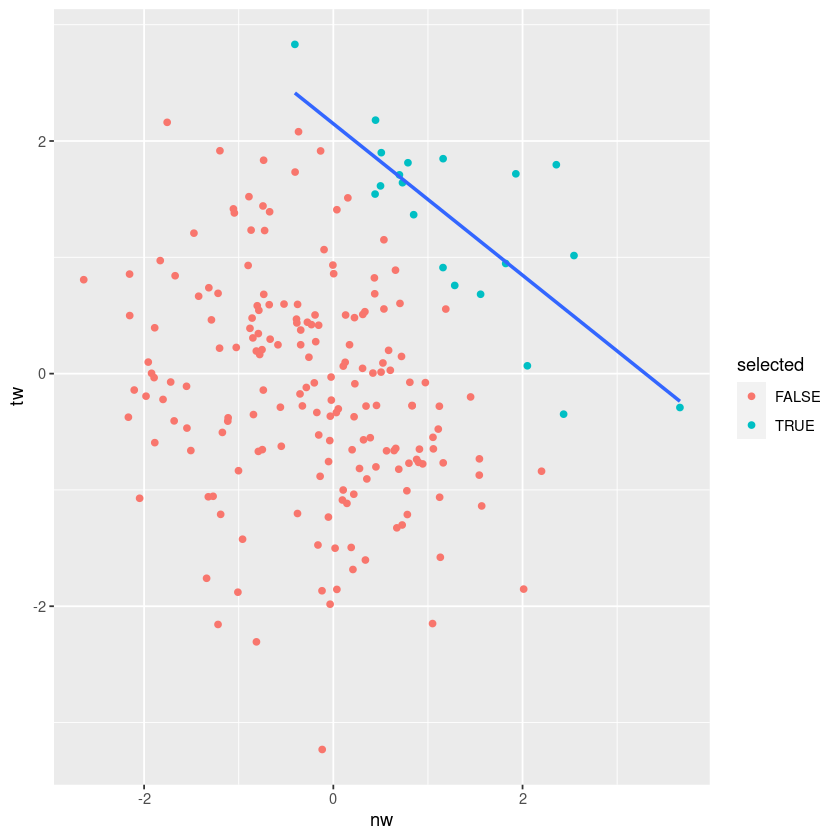

In [3]:
plot_df <- data.frame(
    nw=nw,
    tw=tw,
    selected=selected
)
ggplot() +
    geom_point(data=plot_df, mapping=aes(x=nw, y=tw, colour=selected)) +
    geom_smooth(data=plot_df[plot_df$selected,], mapping=aes(x=nw, y=tw), method='lm', formula='y~x', se=F)

From the plot, it's clear - even though there was no a priori correlation between trustworthiness and newsworthiness, the selection criteria caused one to appear!

This phenomenon has been recognized for a while, and is called *Berkson's Paradox*. We can also call it the *selection-disortion effect*. It happens a lot!

What does this have to do with regression? Everything! In the previous chapter, we used regression to find out lots of stuff. Obvious temptation is to just throw every piece of data we have into the model and let regression sort it out. Unfortunately, that won't work. Selection-distortion can happen inside a model - the act of adding a predictor induces statistcl selection within the model. This is called *collider bias*.

This can mislead us into e.g. believing that there's a negative correlation between newsworthiness and trustworthiness when really it's just an effect of conditioning on some variable. This is both deeply confusing and very important to understand!

In this chapter, we'll look at three ways that things can go wrong:
1. Multicollinearity
1. Post-treatment bias
1. Collider bias

## Multicollinearity

Usually, there are lots of variables that we *could* include in a model. For instance, in the primate milk one, there are 7 variables. Why not just include them all and let the regression model sort out which ones are useful?

One hazard: **multicollinearity**. This is when there is a strong association between one or more predictor variables. The raw correlation isn't what matters - instead, it's the association, conditional on the othervariables in the model.

The consequence is that the posterior distribution will say that none of the variables are reliably associated with the outcome, even if all of the variables are in reality strongly associated with the outcome.

### Multicollinear Legs

Imagine trying to predict an individual's height from the length of their legs. In fact there is a strong correlation between leg length and height, but when we add both left and right legs into the model something interesting will happen.

In [4]:
N <- 100
set.seed(909)
height <- rnorm(N, 10, 2)
leg_prop <- runif(N, 0.4, 0.5) # leg length as proportion of height
leg_left <- leg_prop * height + rnorm(N, 0, 0.02) # add some error
leg_right <- leg_prop * height + rnorm(N, 0, 0.02) # add some error

d <- data.frame(height, leg_left, leg_right)

Prediction: on average, an individual's leg is 45% of their total height. The beta coefficient for the association of each leg with the height to be about the average height (10) divided by the leg length (0.45 * 10 = 4.5), which is $10 / 4.5 \approx 2.2$.

In [5]:
m6.1 <- quap(
    alist(
        height ~ dnorm(mu, sigma),
        mu <- a + bl*leg_left + br*leg_right,
        a ~ dnorm(10, 100),
        bl ~ dnorm(2, 10),
        br ~ dnorm(2, 10),
        sigma ~ dexp(1)
    ),
    data=d
)
precis(m6.1)

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
a,0.9812791,0.28395540,0.5274635,1.4350947
bl,0.2118585,2.52703706,-3.8268348,4.2505518
br,1.7836774,2.53125061,-2.2617500,5.8291047
sigma,0.6171026,0.04343427,0.5476862,0.6865189


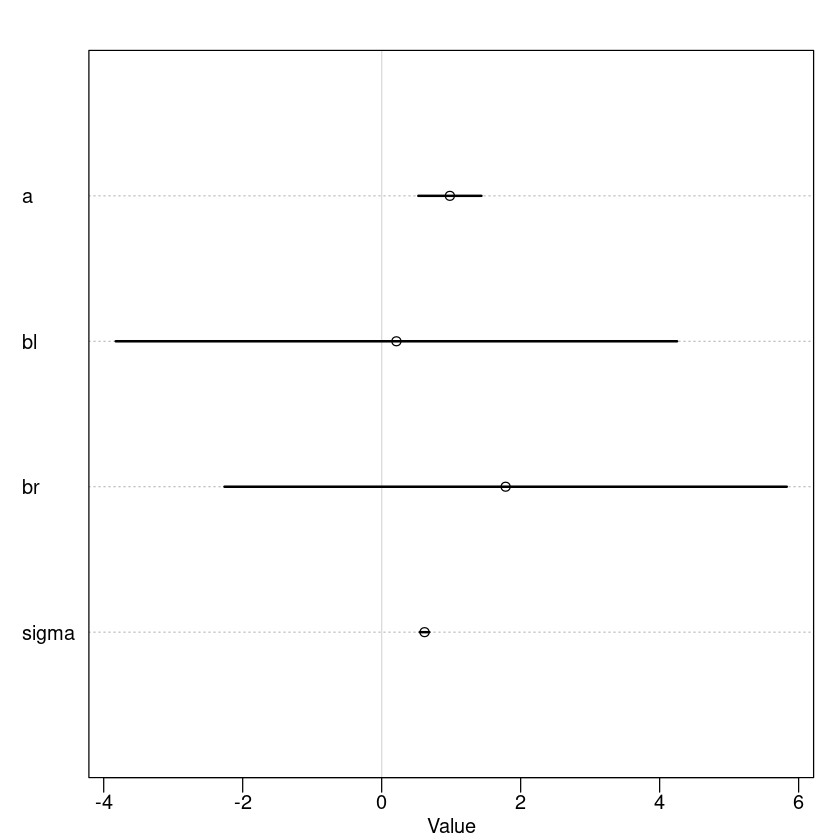

In [6]:
plot(precis(m6.1))

This looks...off

This did work correctly! Recall that the regression coefficient answers the question *what is the value of knowing the value of this predictor after knowing the value of all of the others*? In our case - *what is the value of knowing (e.g.) the length of the left leg after already knowing the length of the right leg?*

It might help to look at the joint distribution of `bl` and `br`:

In [7]:
post <- extract.samples(m6.1)
head(post)

,a,bl,br,sigma
,<dbl>,<dbl>,<dbl>,<dbl>
1,0.9347543,2.2305802,-0.2250780,0.6546926
2,0.9650736,0.1506907,1.8338972,0.5358514
3,1.0010675,1.2853339,0.6866805,0.5779379
4,0.8652994,0.8026564,1.2359107,0.5437995
5,0.6696203,-0.2450609,2.3230420,0.6662594
6,1.1368905,-2.3535731,4.3031799,0.6409561


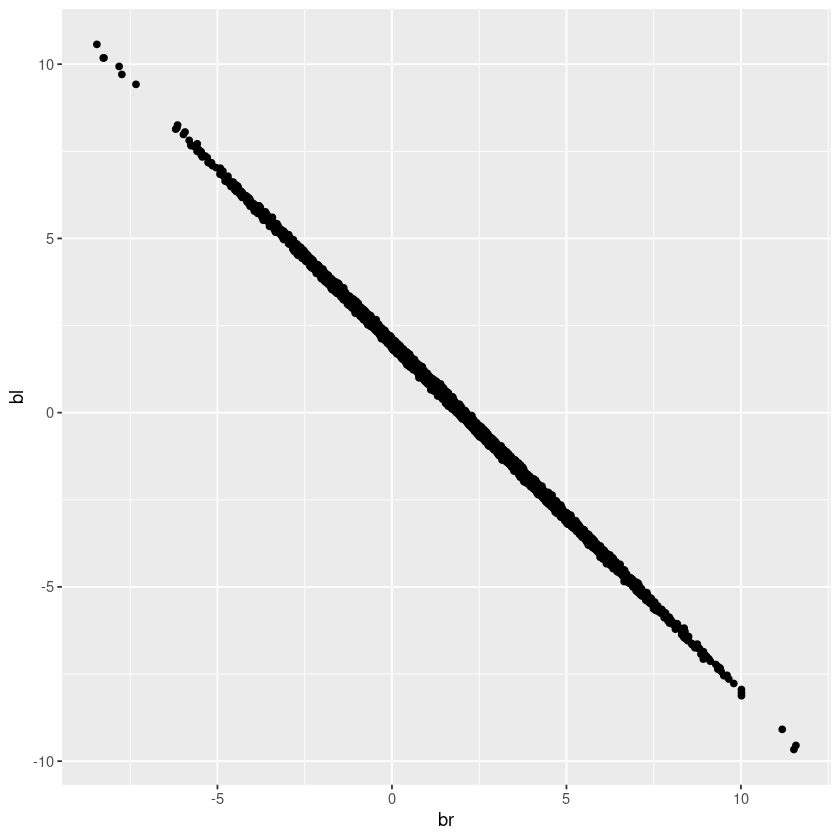

In [8]:
ggplot(post, aes(br, bl)) +
    geom_point()

The posterior distribution for the two is heighly correlated, with the plausible values for `bl` and `br` lying along a narrow ridge. This means the when e.g. `br` is large, `bl` mus be small. Since both variables contain basically exactly the same information, if you insist on including both then there will be a practically infinite number of combinations of `bl` and `br` that end up producing the same predictions - all the values along that narrow ridge!

One way that you can think about this is that since the information in the two variables is basically the same, we're kind of approximating the following model:

$$
\begin{align*}
y_i &\sim Normal(\mu_i, \sigma) \\
\mu_i &\sim \alpha + \beta_1 x_i + \beta_2 x_i
\end{align*}
$$

Here $x$ is used twice, and so from the model's perspective, this looks like

$$
\begin{align*}
y_i &\sim Normal(\mu_i, \sigma) \\
\mu_i &\sim \alpha + (\beta_1 + \beta_2) x_i
\end{align*}
$$

this means that the posterior distributions end up reporting all the plausible values of $\beta_1$ and $\beta_2$ which sum to the actual correlation between $x$ and $y$ - of which there are a lot!

In fact, we can see this if we look instead at the *sum* of `bl` and `br`:

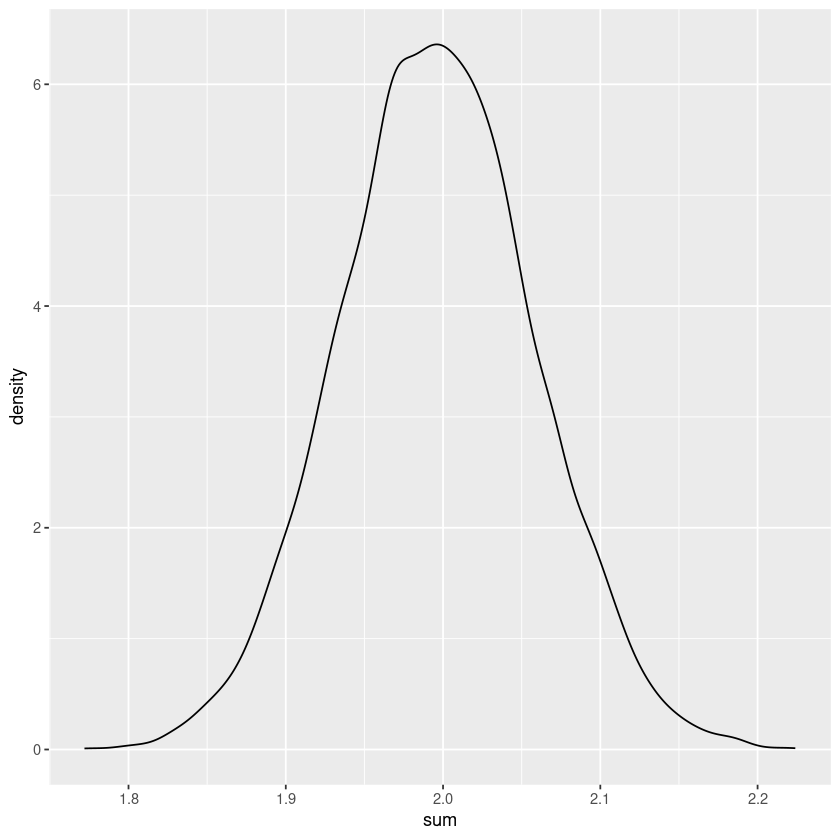

In [9]:
post$sum <- post$br + post$bl
ggplot(post, aes(x=sum)) +
    geom_density()

So the *sum* of these is in basically the right range - a little over 2, with a reasonable standard deviation.

If we fit a model with only one of the leg lengths, we get approximately the same posterior mean:

In [10]:
m6.2 <- quap(
    alist(
        height ~ dnorm(mu, sigma),
        mu <- a + bl*leg_left,
        a ~ dnorm(10, 100),
        bl ~ dnorm(2, 10),
        sigma ~ dexp(1)
    ),
    data=d
)
precis(m6.2)

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
a,0.9979326,0.28364620,0.5446112,1.451254
bl,1.9920676,0.06115704,1.8943269,2.089808
sigma,0.6186038,0.04353998,0.5490185,0.688189


The value of `bl=1.99` is essentially what we expected.

Basic lesson: if you have two predictor variables which are strongly correlated, then including both in the model (conditional on other things in the model) can lead to confusion. 

The posterior distribution isn't wrong - it's just telling you that you can't answer the question you asked using that model. Which is actually kind of a good thing for your model to tell you! Also, if you are interested in prediction, then the leg model will actually generate good predictions - it just won't tell you which leg is more important!

### Multicollinear Milk

Let's look at a real-world example using the primate milk data.

In [11]:
data(milk)
d <- milk
d$K <- standardize(d$kcal.per.g)
d$F <- standardize(d$perc.fat)
d$L <- standardize(d$perc.lactose)

We're interested in modelling the calories asa function of the percent fat and percent lactose. We'll start with two bivariate regression (calories against each individually):

In [12]:
# kcal per gram against perc.fat
m6.3 <- quap(
    alist(
        K ~ dnorm(mu, sigma),
        mu <- a + bF * F,
        a ~ dnorm(0, 0.2),
        bF ~ dnorm(0, 0.5),
        sigma ~ dexp(1)
    ),
    data=d
)

# kcal per gram against perc.lactose
m6.4 <- quap(
    alist(
        K ~ dnorm(mu, sigma),
        mu <- a + bL * L,
        a ~ dnorm(0, 0.2),
        bL ~ dnorm(0, 0.5),
        sigma ~ dexp(1)
    ),
    data=d
)

precis(m6.3)
precis(m6.4)

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
a,1.535526e-07,0.07725195,-0.1234634,0.1234637
bF,8.618970e-01,0.08426088,0.7272318,0.9965621
sigma,4.510179e-01,0.05870756,0.3571919,0.5448440


,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
a,7.438895e-07,0.06661633,-0.1064650,0.1064665
bL,-9.024550e-01,0.07132848,-1.0164517,-0.7884583
sigma,3.804653e-01,0.04958259,0.3012227,0.4597078


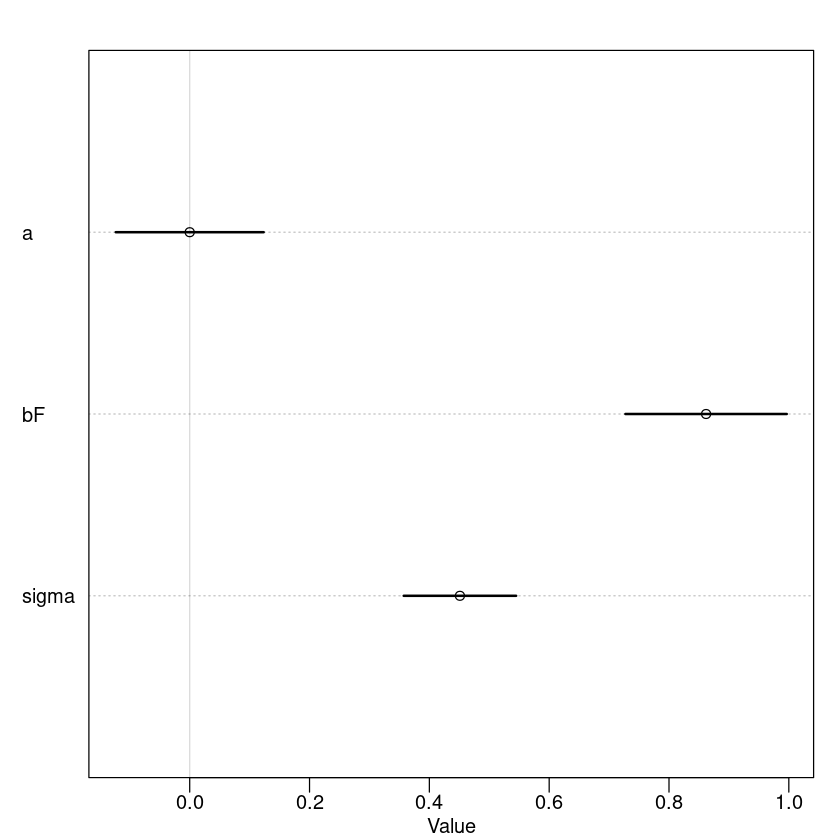

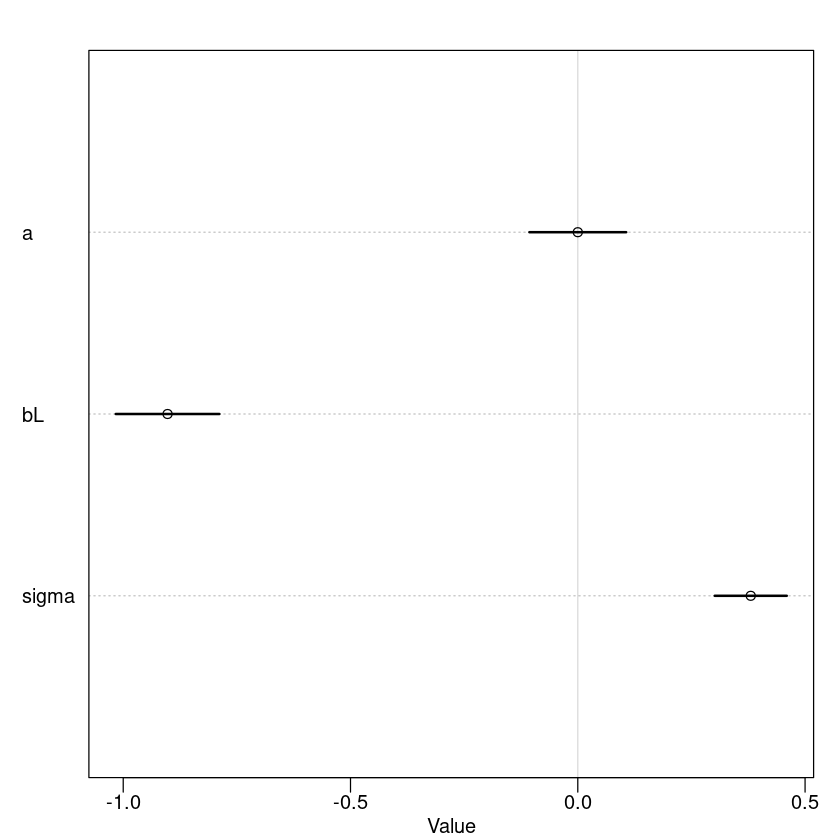

In [13]:
plot(precis(m6.3))
plot(precis(m6.4))

Both are highly correlated and basically the mirror image of the other. We migth conclude that both variables are reliable predictors of the total energy - the more fat, the more energy; the more lactose, the less the energy. Now we'll add both to the same model:

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
a,-4.429949e-07,0.06603529,-0.10553759,0.1055367
bL,-6.780787e-01,0.18377563,-0.97178761,-0.3843697
bF,2.435019e-01,0.18357757,-0.04989054,0.5368943
sigma,3.767387e-01,0.04918293,0.29813489,0.4553426


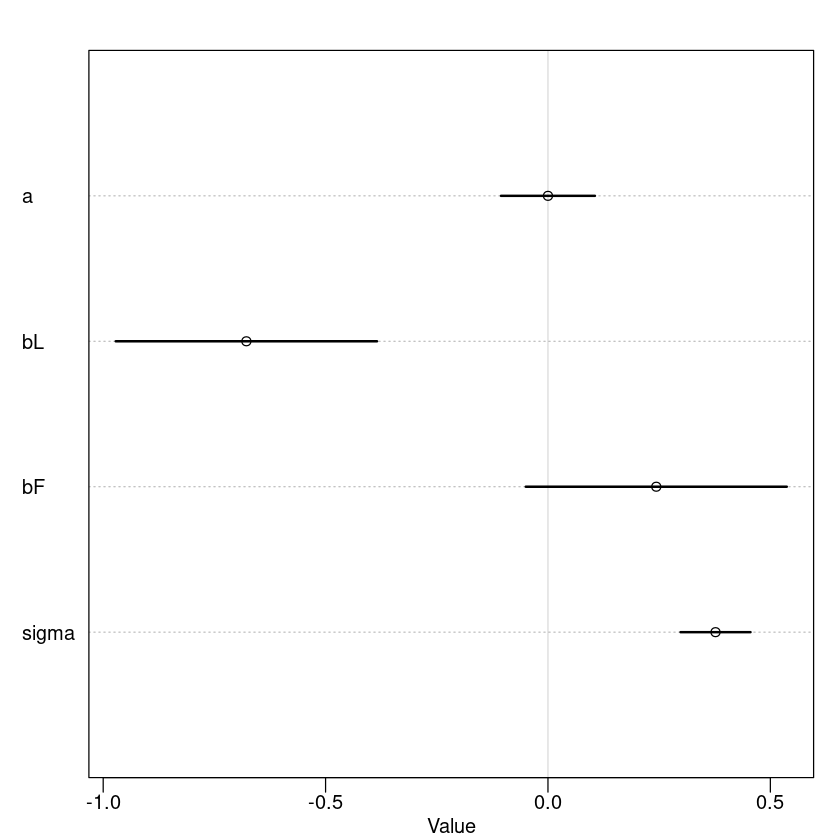

In [14]:
m6.5 <- quap(
    alist(
        K ~ dnorm(mu, sigma),
        mu <- a + bL * L + bF * F,
        a ~ dnorm(0, 0.2),
        bL ~ dnorm(0, 0.5),
        bF ~ dnorm(0, 0.5),
        sigma ~ dexp(1)
    ),
    data=d
)

precis(m6.5)
plot(precis(m6.5))

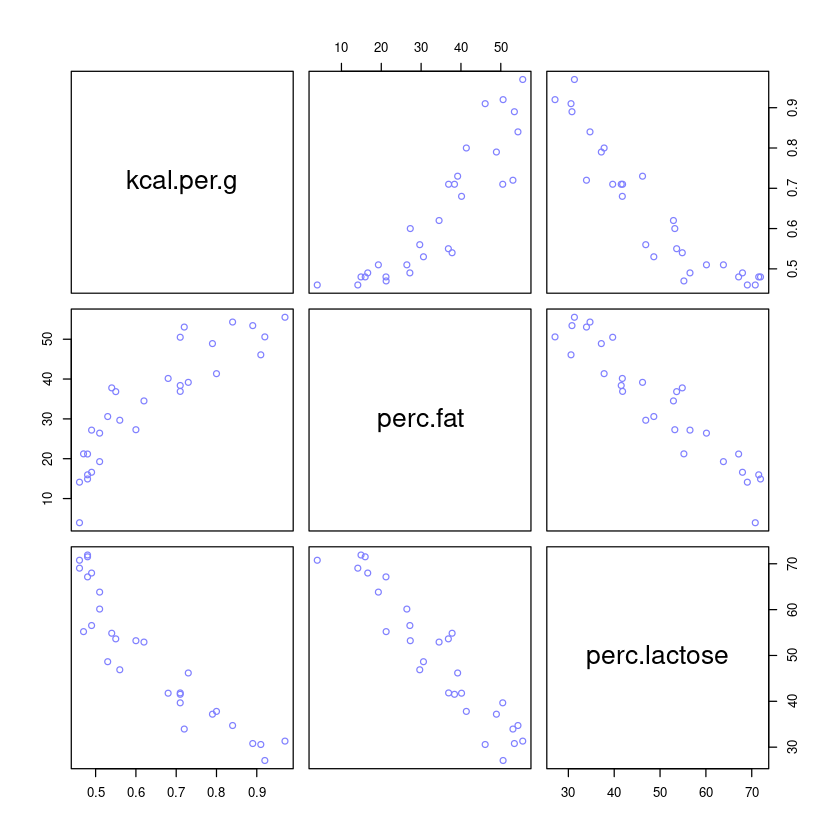

In [15]:
pairs( ~kcal.per.g + perc.fat + perc.lactose, data=d, col=rangi2)

For `pairs`, the vertical axis is the variable in the same row and the horizontal one is the variable in the same column.

You can see that each is correlated with the calories (but in opposite directions), and also that they're strongly correlated with each other. Just like in our previous example, they contain basically the same information.

There are a few solutions.

One method: inspect for pairwise correlations *before* fitting the model and drop one of them. This is a mistake - the problem isn't the correlation, it's the conditional associations.

We should take a *causal* perspective and try to see what is going on.

What is likely going on the milk example is that there is a tradeoff in milk composition in mammals. If they nurse often, the milk tends to be watery and low in energy (high in lactose). If they nurse infrequently, then the milk is higher in energy (and fat). This implies a causal model something like this:

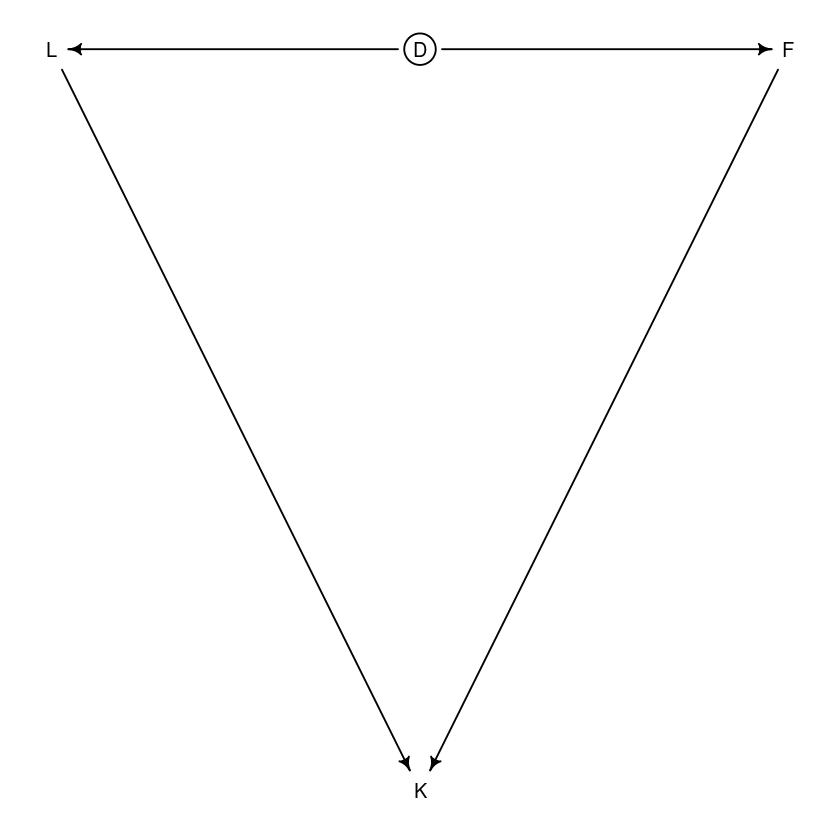

In [16]:
dag <- dagitty(
    'dag{
        D [latent, pos="0,0"]
        L [pos="-1,0"]
        F [pos="1,0"]
        K [pos="0,1"]
        L <- D -> F
        F -> K
        L -> K
    }'
)
drawdag(dag)

Here we have a latent variable representing the density of the milk.

The problem of collinearity is part of a family of problems with model fitting known as **non-identifiability**. When a parameter is *non-identifiable*, it means that the structure of the model and/or data make it so that it isn't possible to estimate the parameter's value. Sometimes it's a mistake, but other times it's just how the world works. "Nature doesn't owe us easy inference, even when the model is correct."

In general, no guarantee that the available data contains information about a parameter of interest. If that's the case, the Bayesian inference model will return a posterior that's basically identical to the prior - after all, you haven't added much information!

Often a good idea to compare the posterior to the prior. If they are very similar it doesn't mean that the calculations are wrong, but it might lead you to ask better questions!

## Post-Treatment Bias

It's natural to worry about bias from *not* including variables. Such mistakes are called **omitted variable bias**, and the examples from the previous chapter illustrate it. Much less common to worry about mistaken inference arising from *included* variables. But **included variable bias** is real! Blindly tossing variables into the causal salad is never a good idea.

*Included variable bias* takes several forms. The first is **post-treatment bias**. Say you are growing some plants in a greenhouse. You want to know the difference in growth under different antifungal soil treatments. Plants are initially seeded and sprout. Teir heights are measured. Then different soil treatments are applied. Final measure are the height of the plant and the presence of fungus. There are four variables of interest here: initial height, final height, treatment, and presence of fungus. But which other variables should be in the model? If the goal is to make a causal inference about the treatment, you *shouldn't* include the presence of fungus - it's a *post-treatment* effect.

Let's run a simulation to make the example more transparent.

In [17]:
set.seed(71)
N <- 100 # number of plants

# initial heights
h0 <- rnorm(N, 10, 2)

#assign treatments and simulate fungus and growth
treatment <- rep(0:1, each=N/2)
fungus <- rbinom(N, size=1, prob=0.5 - treatment * 0.4)
h1 <- h0 + rnorm(N, 5 - 3 * fungus)

# clean data frame
d <- data.frame(h0=h0, h1=h1, treatment=treatment, fungus=fungus)
precis(d)

,mean,sd,5.5%,94.5%,histogram
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
h0,9.95978,2.1011623,6.570328,13.07874,▁▂▂▂▇▃▂▃▁▁▁▁
h1,14.39920,2.6880870,10.618002,17.93369,▁▁▃▇▇▇▁▁
treatment,0.50000,0.5025189,0.000000,1.00000,▇▁▁▁▁▁▁▁▁▇
fungus,0.23000,0.4229526,0.000000,1.00000,▇▁▁▁▁▁▁▁▁▂


### A Prior is Born
When designing the model, you want to pretend you don't have the data generation process above.

We know that plants at `t=1` should be taller than those at `t=0`. Thus, we can put the parameters on a scale of *proportion* of height at `t=0` to hep us set the priors.

To start, let's ignore the predictor variables. Then we might start with a simple model like
$$
\begin{align*}
h_{1,i} &\sim \text{Normal}(\mu_i, \sigma) \\
\mu_i &= h_{0,i} \times p
\end{align*}
$$

The proportion $p$ should be positive, and we can allow it to fall below 1 in case there is some shrinkage (=death) of the plants. We'll fit a log-normal:

In [18]:
sim_p <- rlnorm(1e4, 0, 0.25)
precis(data.frame(sim_p))

,mean,sd,5.5%,94.5%,histogram
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
sim_p,1.03699,0.2629894,0.670683,1.496397,▁▁▃▇▇▃▁▁▁▁▁▁


So from the prior we expect anywhere from a 30% shrinkage to 50% growth.

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
p,1.426626,0.01760992,1.398482,1.454770
sigma,1.793286,0.12517262,1.593236,1.993336


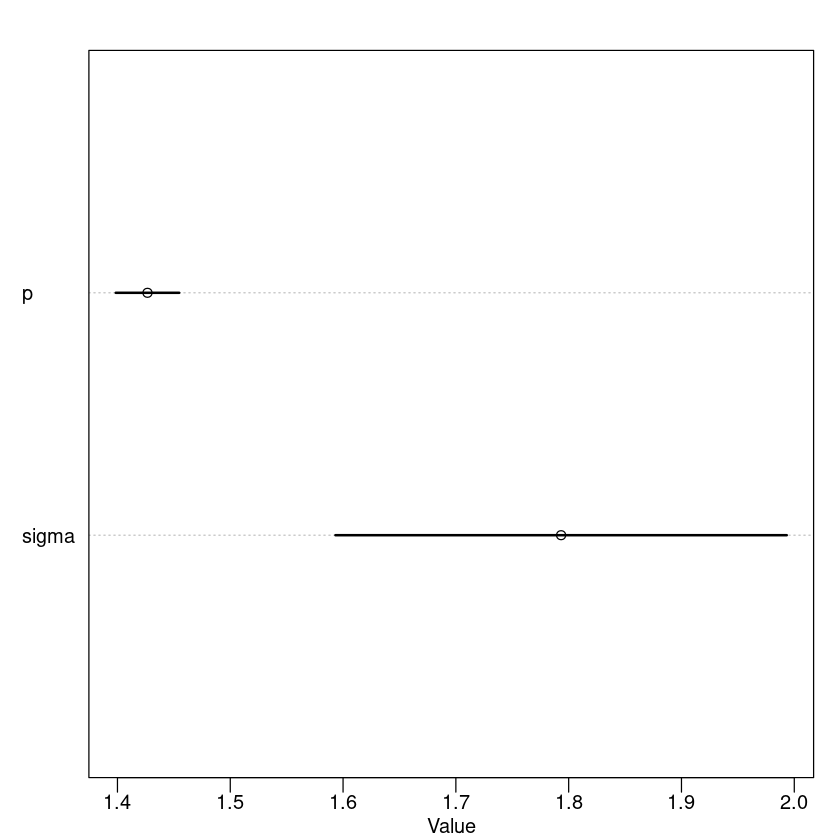

In [19]:
m6.6 <- quap(
    alist(
        h1 ~ dnorm(mu, sigma),
        mu <- h0 * p,
        p ~ dlnorm(0, 0.25),
        sigma ~ dexp(1)
    ),
    data=d
)
precis(m6.6)
plot(precis(m6.6))

Now let's try including the treatment and fungus variables. The parameters for those will be on the proportions scale - they will be changes in the proportion of growth.

$$
\begin{align*}
h_{1,i} &\sim \text{Normal}(\mu_i, \sigma)\\
\mu_i &\sim h_{0,i} \times p \\
p &= \alpha + \beta_T * T_i + \beta_F * F_i \\
\alpha &\sim \text{Log-Normal}(0, 0.25) \\
\beta_T &\sim \text{Normal}(0, 0.5) \\
\beta_F &\sim \text{Normal}(0, 0.5) \\
\sigma &\sim \text{Exponential}(1) \\
\end{align*}
$$

These priors are almost certainly too flat.

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
a,1.481391468,0.02451069,1.44221865,1.52056429
bt,0.002412222,0.02986965,-0.04532525,0.05014969
bf,-0.266718915,0.03654772,-0.32512923,-0.20830860
sigma,1.408797442,0.09862070,1.25118251,1.56641237


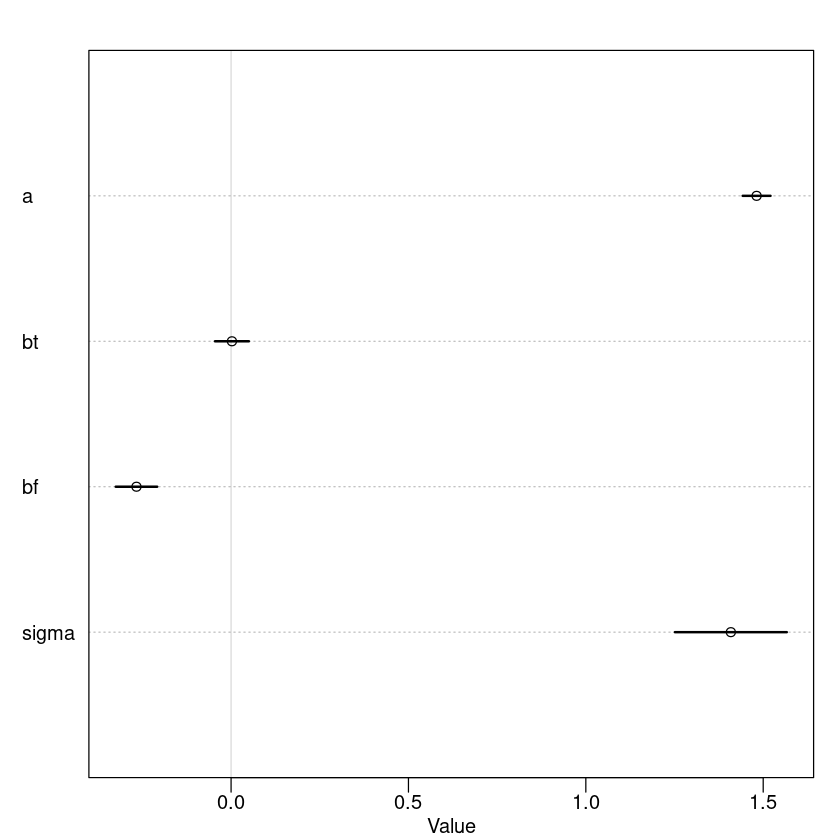

In [20]:
m6.7 <- quap(
    alist(
        h1 ~ dnorm(mu, sigma),
        mu <- h0 * p,
        p <- a + bt*treatment + bf*fungus,
        a ~ dlnorm(0, 0.2),
        bt ~ dnorm(0, 0.5),
        bf ~ dnorm(0, 0.5),
        sigma ~ dexp(1)
    ),
    data=d
)
precis(m6.7)
plot(precis(m6.7))

`a` basically looks like `p` before, and `bt` is tight around 0. We know the treatment matters - after all, we built it into the simulation. So what's going on?

### Blocked by Consequence
The problem is that `fungus` is mostly a consequence of `treatment`. That is - `fungus` is a *post-treatment variable*. When we control for `fungus`, the model is answering the question, 'once we already know wheter or not a plant developed fungus, does soil treatment matter?' The answer here is clearly no - the treatment has its effect by controlling the fungus! What we actually want to know is the impact of the treatment on growth. To measure it properly, we should *omit* the post-treatment variable.

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
a,1.38035767,0.02517554,1.34012229,1.4205931
bt,0.08499924,0.03429718,0.03018573,0.1398128
sigma,1.74631655,0.12191552,1.55147200,1.9411611


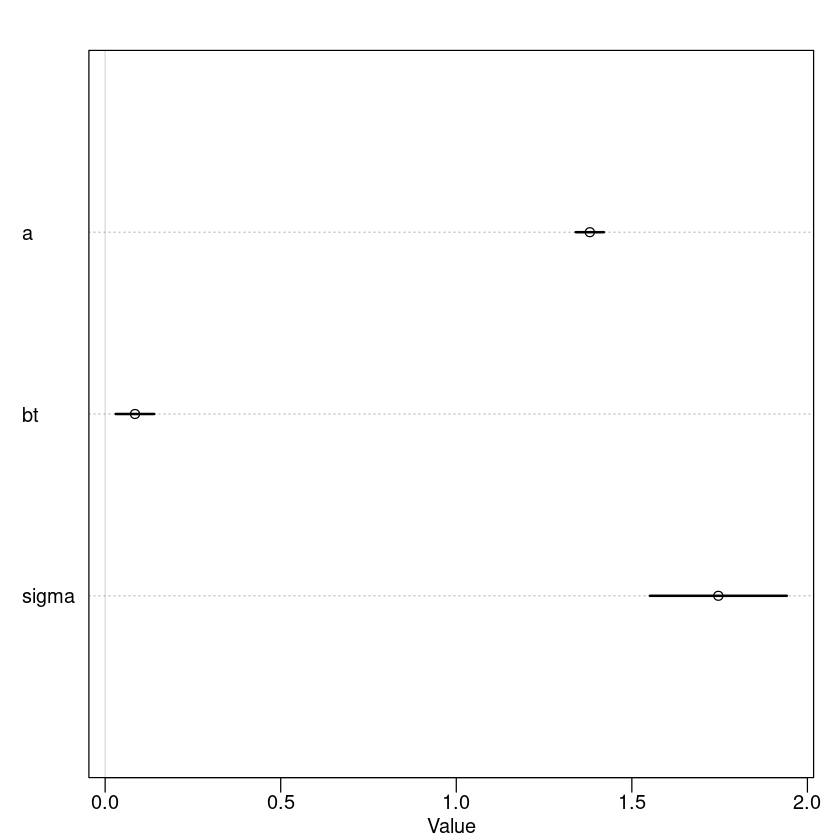

In [21]:
m6.8 <- quap(
    alist(
        h1 ~ dnorm(mu, sigma),
        mu <- h0 * p,
        p <- a + bt*treatment,
        a ~ dlnorm(0, 0.2),
        bt ~ dnorm(0, 0.5),
        sigma ~ dexp(1)
    ),
    data=d
)
precis(m6.8)
plot(precis(m6.8))

So now the treatment is clearly positive, as it should be.

Bottom line: including post-treatment variables can mask the effect of the treatment.

### Fungus and d-separation

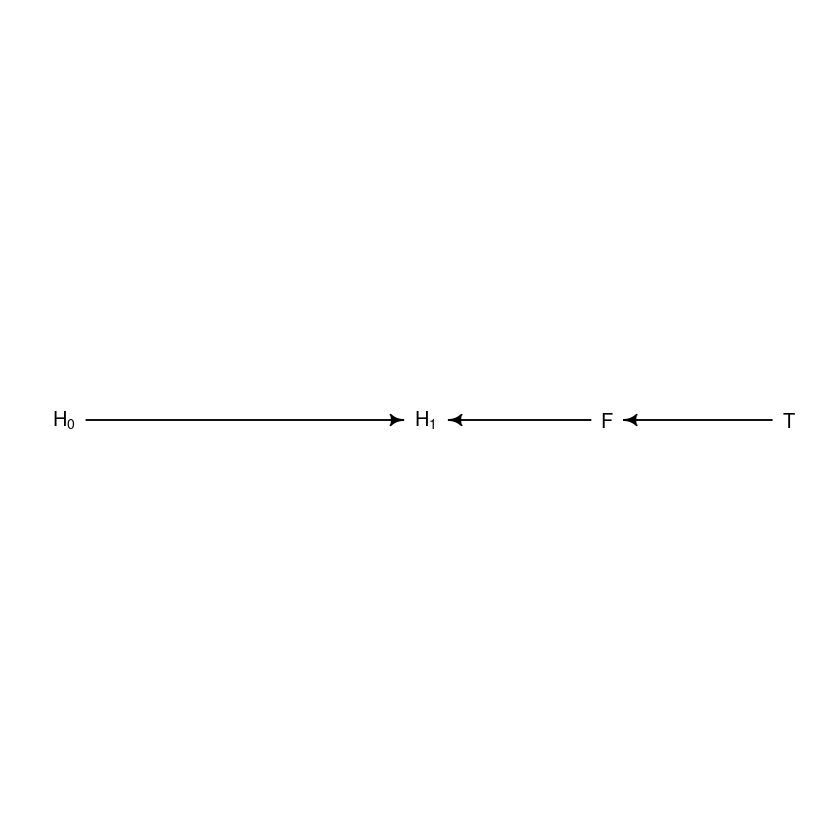

In [22]:
plant_dag <- dagitty(
    'dag {
        H_0 [pos="0,0"]
        H_1 [pos="1,0"]
        F [pos="1.5,0"]
        T [pos="2,0"]
        H_0 -> H_1
        T -> F -> H_1
    }'
)
drawdag(plant_dag)

When we include `F`, we *block* the path from the treatment to the outcome.

Another way of saying this is that conditioning on `F` induces **d-separation**. The 'd' stands for 'directional'. D-separation means that some variables on a directed graph are independent of others - there is no path connecting them. In this case, $H_1$ is d-separated from $T$, but only when we condition on $F$. This implies a *conditional independence*:

In [23]:
impliedConditionalIndependencies(plant_dag)

F _||_ H_0
H_0 _||_ T
H_1 _||_ T | F

The last one is what we're talking about, but the other two also provide tests for the DAG. What $F \perp H_0$ and $H_0 \perp T$ say is that the original plant height, $H_0$, should be independent of the treatment and fungus, provided we do not condition on anything.

Obviously, the problem of post-treatment effects applies to observational studies as well as to experiments. With observational studies, it can be harder to tell what actually is the post-treatment effect. However, there are traps in experimental studies as well. For instance, conditioning on a post-treatment effect can actually fool you into thinking that the treatment works when it doesn't!

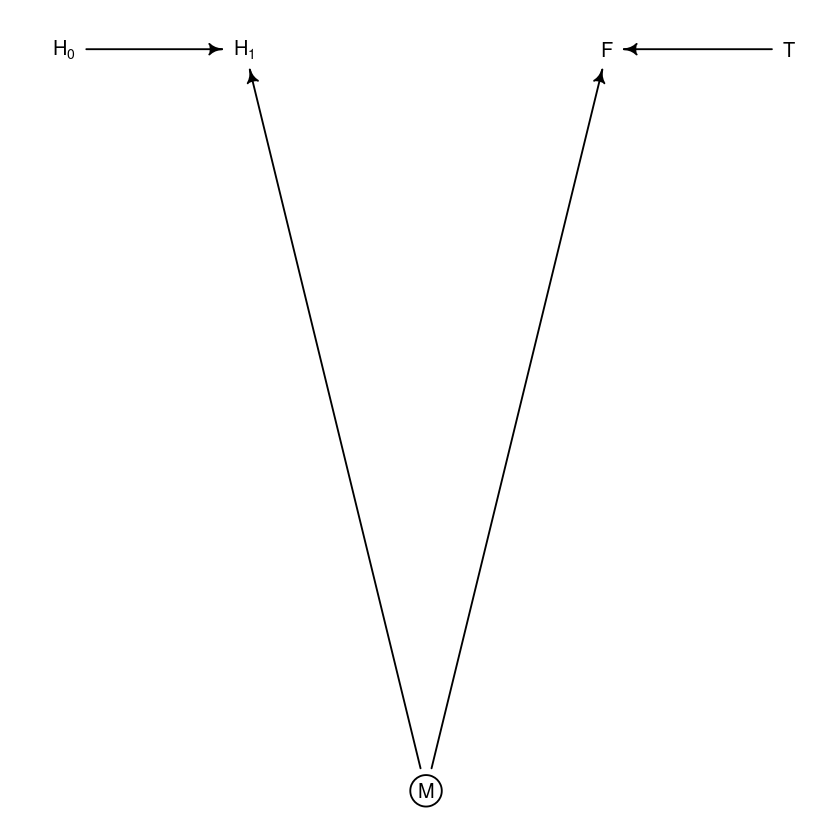

In [24]:
bad_dag <- dagitty(
    'dag{
        H_0 [pos="-1,0"]
        H_1 [pos="-0.5,0"]
        M [latent, pos="0,0.5"]
        F [pos="0.5,0"]
        T [pos="1,0"]
        H_0 -> H_1
        F <- M -> H_1
        T -> F
    }'
)
drawdag(bad_dag)

In this model, we have an unobserved variable, `M` (moisture). The plant isn't actually bothered by the fungus, but it is affected by the moisture (it grows more), as is the fungus. Thus, since moisture affects *both* the fungus and the final height, if we condition on the fungus we'll think that the treatment actually worked when really it did not.

## Collider Bias

Earlier, we saw that all that was required for the negative association between newsworthiness and trustworthiness was that the selection criteria cared about both. This can also happen inside statistial models. When it does, it's called **collider bias** and can seriously distort our inferences.

The DAG for this model is

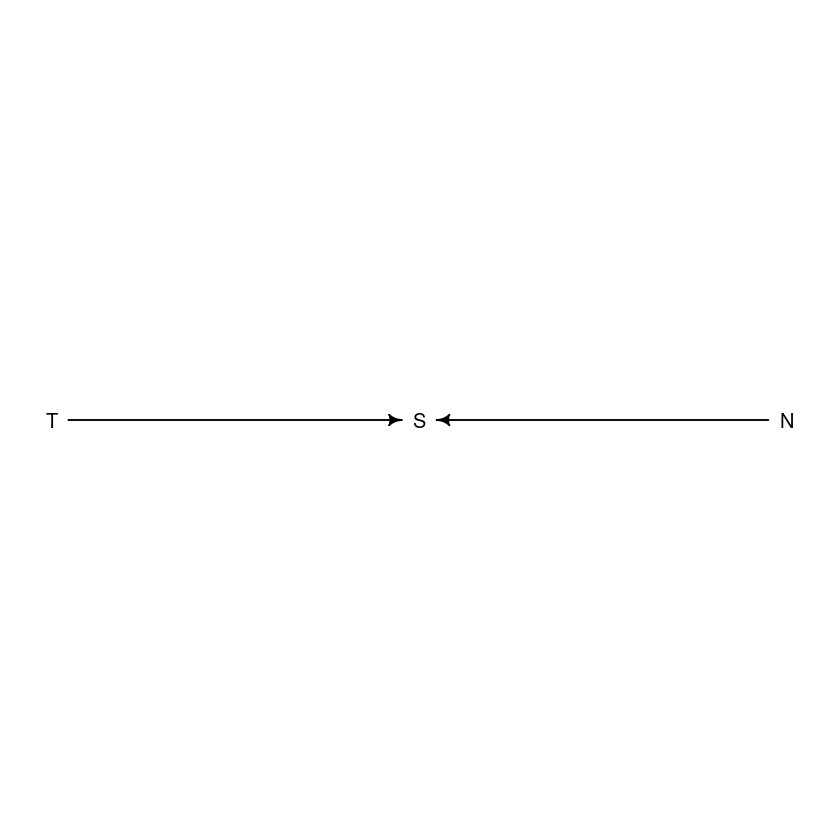

In [25]:
papers_dag <- dagitty(
    'dag{
        T [pos="-1,0"]
        S [pos="0,0"]
        N [pos="1,0"]
        T -> S
        N -> S
    }'
)
drawdag(papers_dag)

Again, we see that neither the trustworthiness (T) or newsworthiness (N) affect one another, but both influence the selection for funding (S).

The fact that two arrows enter $S$ means that it is a **collider**. The core concept is: when you condition on a collider, it creates a statistical - but not necessarily causal - association among its causes. In this case, if you learn that a proposal has been accepted and you know something about its newsworthiness, that also tells you something about its trustworthiness.

Why? For instance, if it has low newsworthiness, then it must have high trustworthiness - otherwise it wouldn't have been selected for funding. This is the informational phenomenon that generates the egative association between `T` and `N` in the population. You have to pay attention to the processes that select our samples of observation from the population. The same phenomenon will also generate isleading association inside a statistical model if you include the collider as a predictor variable.

### Collider of false sorrow

Consider the question of how aging influences happiness. If we have a large suvery of people rating how happy they are, is there a connection between age and happiness? If so, is that association causal? Here, we'll see how controlling for a plausible confound can actually bias inference about the influence of age.

Say that an individual's happiness is fixed at birth. However, happiness does influece events like marriage. Happier people are more likely to get married. Another variable that influences marriage is age: the more years you are alive, the more likely you are to eventually get married. Our causal model now looks like this:

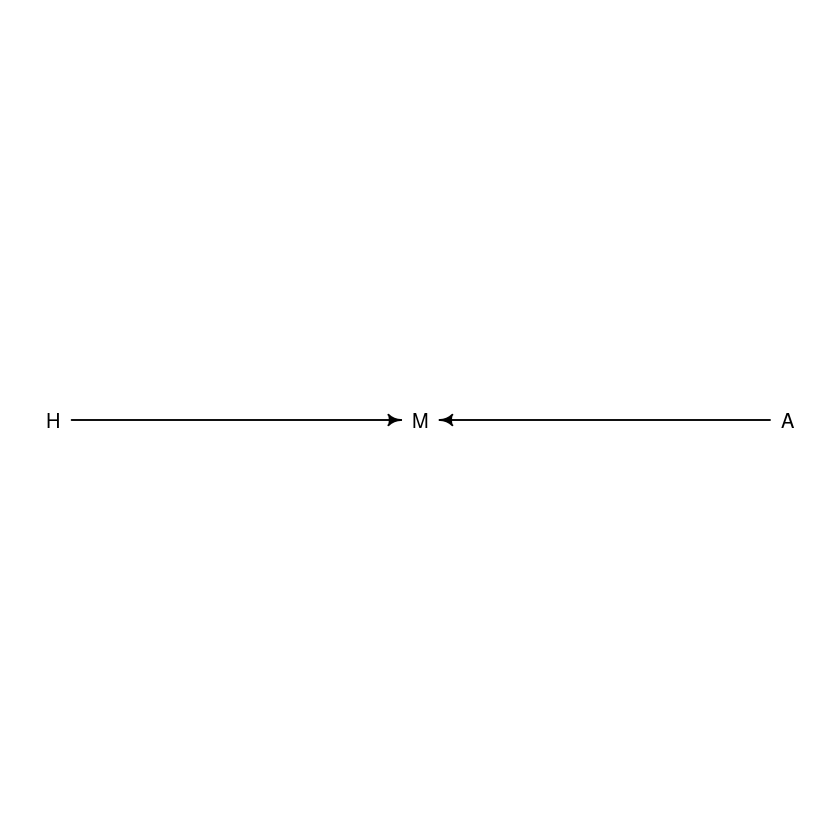

In [26]:
happiness_dag <- dagitty(
    'dag{
        H [pos="-1,0"]
        M [pos="0,0"]
        A [pos="1,0"]
        H -> M
        A -> M
    }'
)
drawdag(happiness_dag)

Here $M$ is a collider. Even though there's no association between age and happiness, conditioning on marriage will lead us to thin that there is.

Let's do another simulation.

1. Each year, 20 people are born with uniformly distributed happiness values
1. Each year, each person ages one year. Happiness does not change.
1. At age 18, people can get married. The odds of marriage each year are proportional to someone's happiness.
1. One married, an individual remains married
1. After age 65, people leave the sample (the move to Spain)

This algorithm exists in the rethinking package. Let's run it for 1000 years:

In [27]:
d <- sim_happiness(seed=1977, N_years=1000)
precis(d)

,mean,sd,5.5%,94.5%,histogram
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
age,3.300000e+01,18.768883,4.000000,62.000000,▇▇▇▇▇▇▇▇▇▇▇▇▇
married,3.007692e-01,0.458769,0.000000,1.000000,▇▁▁▁▁▁▁▁▁▃
happiness,-1.000070e-16,1.214421,-1.789474,1.789474,▇▅▇▅▅▇▅▇


In [28]:
head(d)

,age,married,happiness
,<dbl>,<dbl>,<dbl>
1,65,0,-2.0000000
2,65,0,-1.7894737
3,65,1,-1.5789474
4,65,0,-1.3684211
5,65,0,-1.1578947
6,65,0,-0.9473684


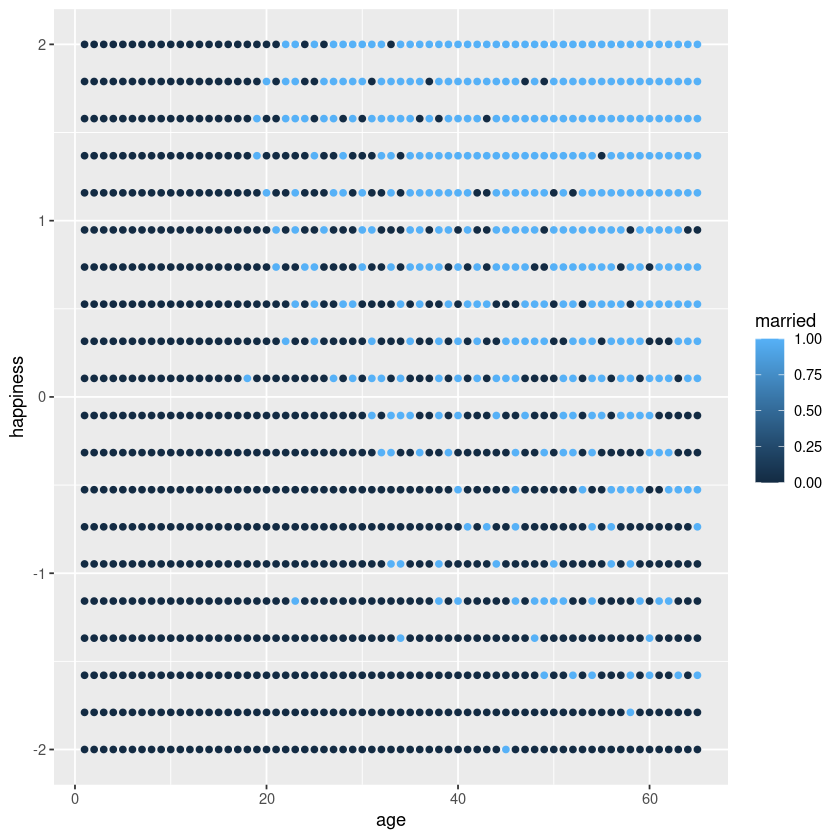

In [29]:
ggplot(d, aes(age, happiness)) +
    geom_point(aes(colour=married))

Say you come across this data and want to ask whether age and happiness are related. You don't know the true causal model, but reasonably suspect that marriage might be a confound. If that's the case (married people are on average more or less happy), then you need to condition on that to get at the relationship between age and marriage.

Then a reasonable model might be

$$
\mu_i = \alpha_{\text{MID[$i$]}} + \beta_A * A
$$

where MID[$i$] is an index for the marriage status of individual $i$, with 1 being single and 2 being married. This is the categorial variable strategy from Chapter 4.

Now for the priors, starting with $\beta_A$. Imagine a very strong relationship, where people are happiest at 18 and then it declines from there. It'll be easier if we rescale so that the ages from 18 - 65 are one unit (0 - 1). Then

In [30]:
d2 <- d[d$age > 17,] # only adults
d2$A <- (d2$age - 18) / (65 - 18)

Now our age runs from 0 - 1 and the happiness runs from -2 to +2 (range 4). Recall that 95% of the mass of a normal distribution is within two standard deviations. Thus, if we set our standard deviation to be half of 4, that says that we expect 95% of plausible slopes to be less than maximally strong. That isn't particularly strong, but it does help keep the values we get reasonable.

Now for the intercepts. Each $\alpha$ is the value of $\mu_i$ when $A_i = 0$ (age = 18). We need to allow $\alpha$ to cover the whole range of happiness values. By the same reasoning as above, Normal($0,1$) should do the trick.

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
a[1],-0.2350877,0.06348986,-0.3365568,-0.1336186
a[2],1.2585517,0.08495989,1.1227694,1.3943340
bA,-0.7490274,0.11320112,-0.9299447,-0.5681102
sigma,0.9897080,0.02255800,0.9536559,1.0257600


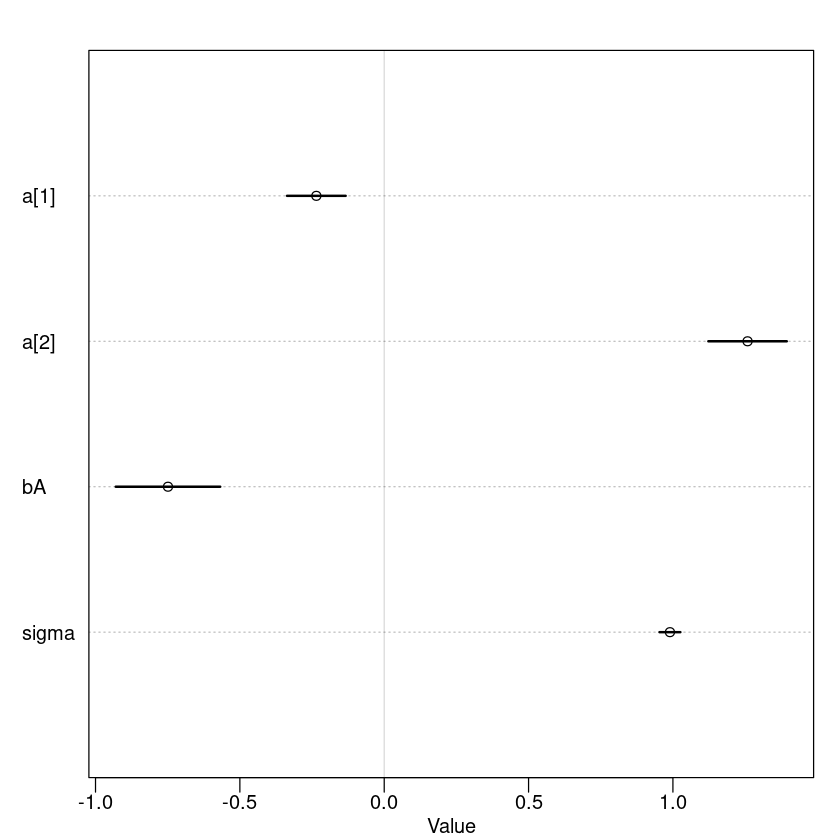

In [31]:
d2$mid <- d2$married + 1
m6.9 <- quap(
    alist(
        happiness ~ dnorm(mu, sigma),
        mu <- a[mid] + bA * A,
        a[mid] ~ dnorm(0, 1),
        bA ~ dnorm(0, 2),
        sigma ~ dexp(1)
    ),
    data=d2
)
precis(m6.9, depth=2)
plot(precis(m6.9, depth=2))

This model is quite sure that age is negatively associated with happiness. Let's compare this to a model that omits marriage status:

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
a,1.649248e-07,0.07675015,-0.1226614,0.1226617
bA,-2.728620e-07,0.13225976,-0.2113769,0.2113764
sigma,1.213188e+00,0.02766080,1.1689803,1.2573949


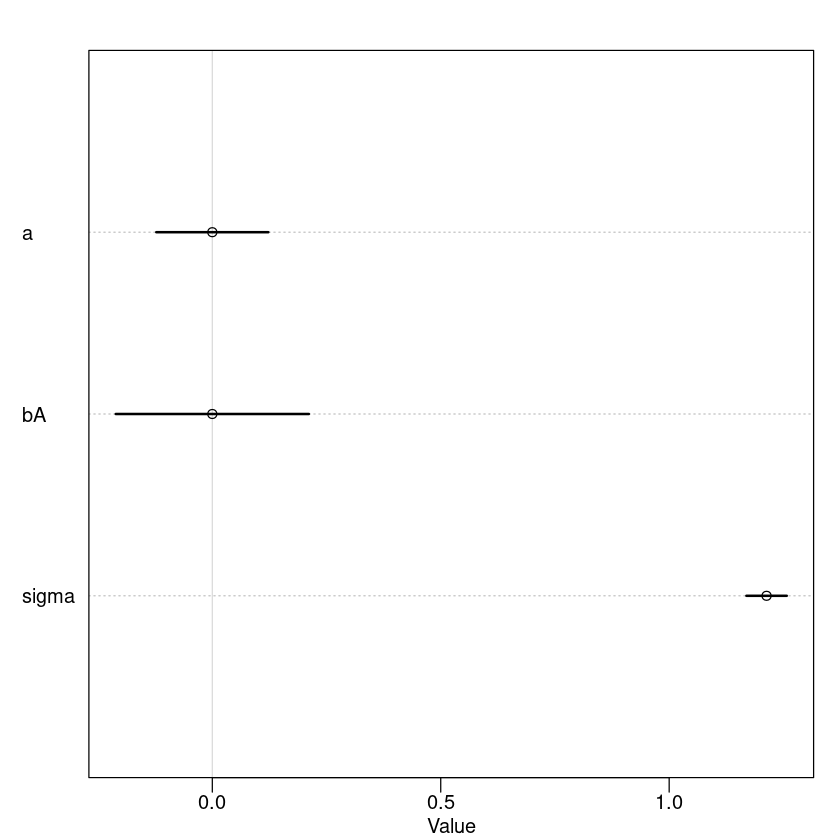

In [32]:
m6.10 <- quap(
    alist(
        happiness ~ dnorm(mu, sigma),
        mu <- a + bA * A,
        a ~ dnorm(0, 1),
        bA ~ dnorm(0, 2),
        sigma ~ dexp(1)
    ),
    data=d2
)
precis(m6.10, depth=2)
plot(precis(m6.10, depth=2))

This one shows that there is no association (the correct answer)!

The pattern above is what we expect when we condition on a collider, marriage status. It is a common consequence of age and hapiness, and so conditioning on it introduces a spurious correlation between the two. Our model `m6.9` found a negative relationship, but it was purely statistical, not causal - once we know someone's marriage state, that tells us something about their happines level.

You can see this in the dots figure. Consider only the married ones. Among the older ones, happiness is lower - more people get married as time goes on, and so the happiness approaches the population mean, 0, making it look like a decrease over time. Now consider the unmarried. Their population falls as times goes on (more people get married), and specifically the happier people get married, causing the mean happienss to fall. Both effects are real, but neither are causative.

You need some science to figure this out!

### The Haunted DAG

Collider ias arises from conditioning on a common consequence. If we can get our graph sorted, we can avoid it! It isn't always so easy to see a potential collider because there may be unmeasured causes. We have to consider the possibility that our DAG is haunted!

Say we want to infer the direct influence of both parents (P) and grandparents (G) on the educational achievement of the children (C). Since grandparents also presumably influence their children, there is an arrow $G \to P$. 

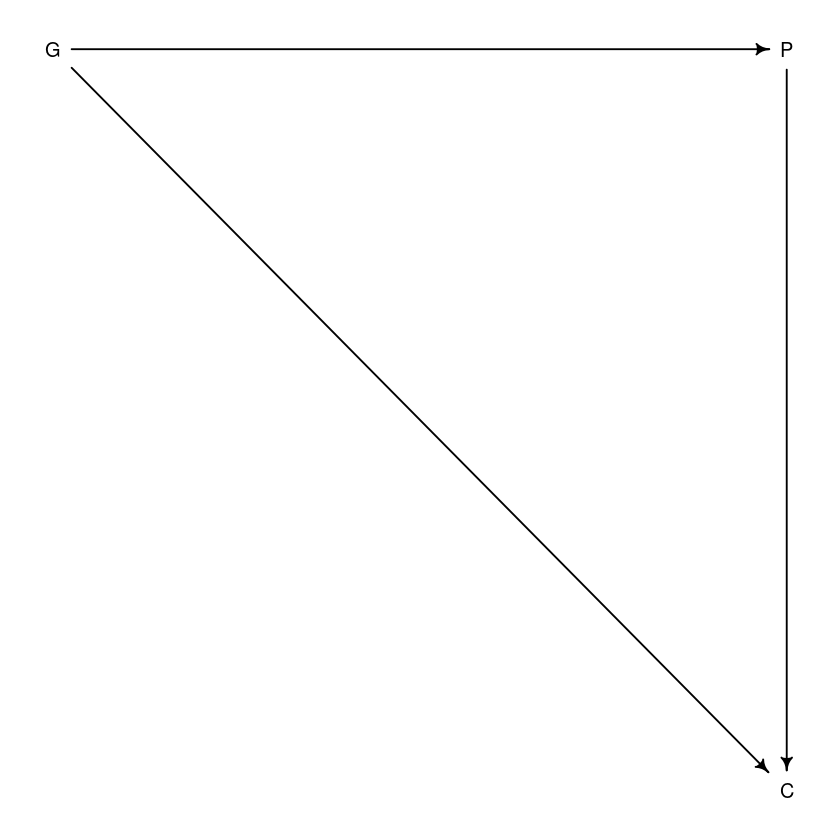

In [33]:
education_dag <- dagitty(
    'dag{
        G[pos="0,0"]
        P[pos="1,0"]
        C[pos="1,1"]
        G -> P -> C
        G -> C
    }'
)
drawdag(education_dag)

But now suppose that there's an unmeasured influece common to $P$ and $C$ (like neighbourhood or something) which is not shared by the grandparents (because they live in Spain now):

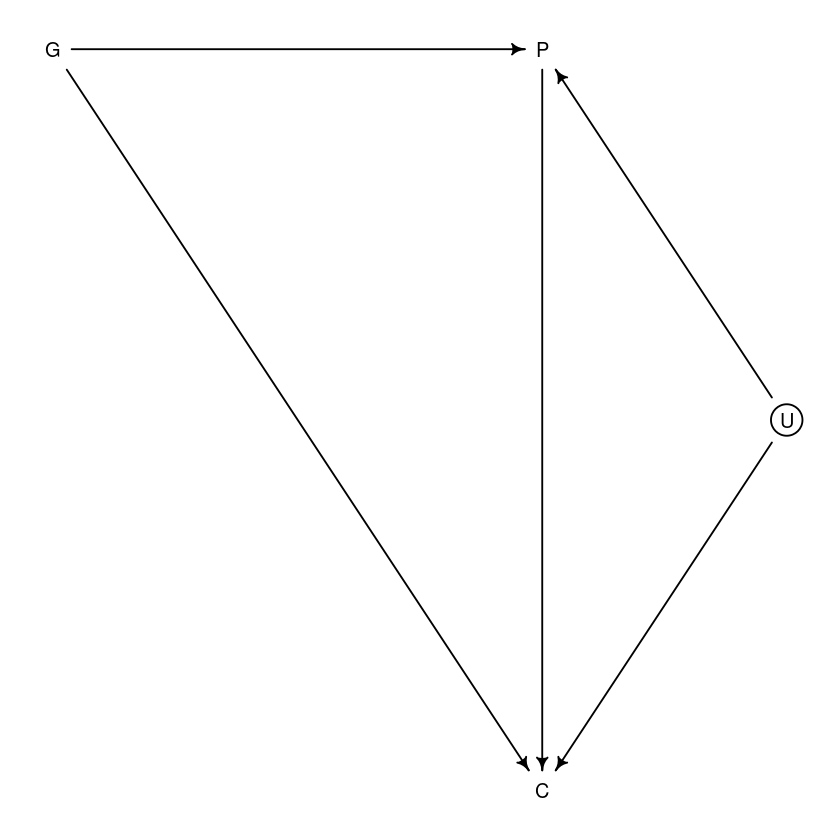

In [34]:
education_dag2 <- dagitty(
    'dag{
        G[pos="0,0"]
        P[pos="1,0"]
        C[pos="1,1"]
        U[latent, pos="1.5, 0.5"]
        G -> P -> C
        G -> C
        P <- U -> C
    }'
)
drawdag(education_dag2)

Now $P$ is a common consequence of $G$ and $U$ (collider!), so if we condition on $P$, it will bias inference about $G \to C$, even if we never get to measure $U$!

Let's do a simulation. We'll simulate 200 triads of $G$, $P$, and $C$. The DAG above implies that
1. P is some function of G and U
1. C is some function of G, P, and U
1. G and U are not function of any other known variables

In [35]:
N <- 200 #number to simulate
b_GP <- 1 # G on P
b_GC <- 0 # G on C
b_PC <- 1 #P on C
b_U <- 2 # U on P and C

Note that in our model, G has no effect on C!

In [36]:
set.seed(1)
U <- 2 * rbern(N, 0.5) - 1
G <- rnorm(N)
P <- rnorm(N, b_GP * G + b_U * U)
C <- rnorm(N, b_PC * P + b_GC * G + b_U * U)
d <- data.frame(C=C, P=P, G=G, U=U)

Notice that the unobserved neighbourhood effect $U$ is just binary - this will make it easier to understand.

Now what happens if we try to infer the effect of G? Since P are involved, we obviously want to control for them:

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
a,-0.1174752,0.09919574,-0.2760091,0.04105877
b_PC,1.7868915,0.04455355,1.7156863,1.85809664
b_GC,-0.8389537,0.10614045,-1.0085867,-0.66932077
sigma,1.4094891,0.07011139,1.2974375,1.52154063


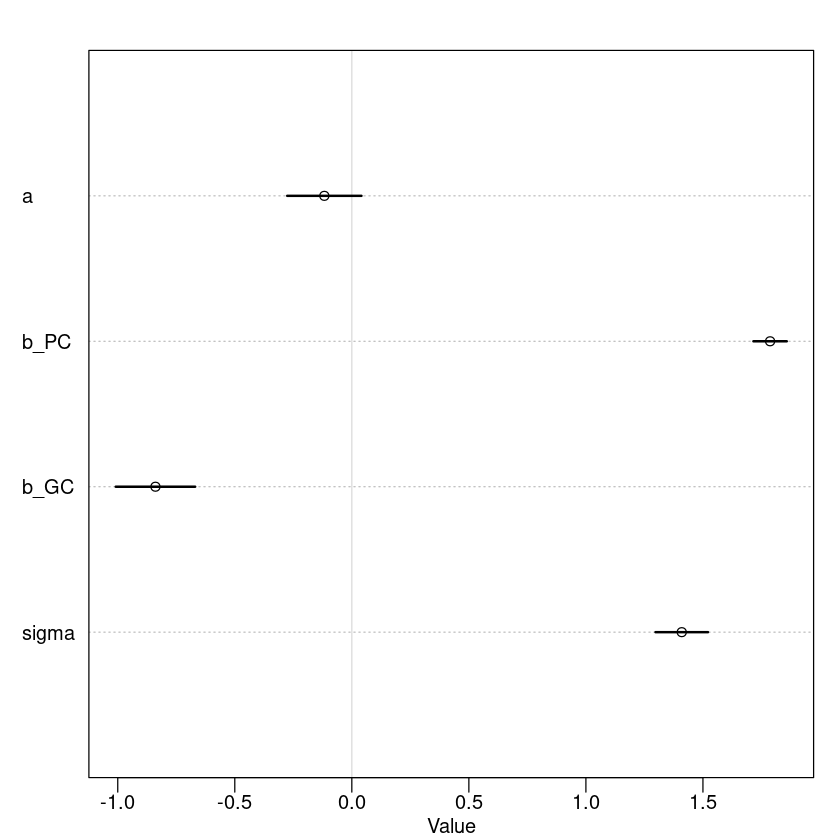

In [37]:
m6.11 <- quap(
    alist(
        C ~ dnorm(mu, sigma),
        mu <- a + b_PC * P + b_GC * G,
        a ~ dnorm(0, 1),
        c(b_PC, b_GC) ~ dnorm(0, 1), # setting both priors at once
        sigma ~ dexp(1)
    ),
    data=d
)
precis(m6.11)
plot(precis(m6.11))

The model is very sure about the effect of parents, but the value is almost twice what it should be! This is a simple confound effect since we're getting the direct effect of parents along with the direct (but unobserved) effect of U.

More suprisingly: the model is very sure that grandparents *hurt* their grandchildren!

Warning message:
“Using size for a discrete variable is not advised.”


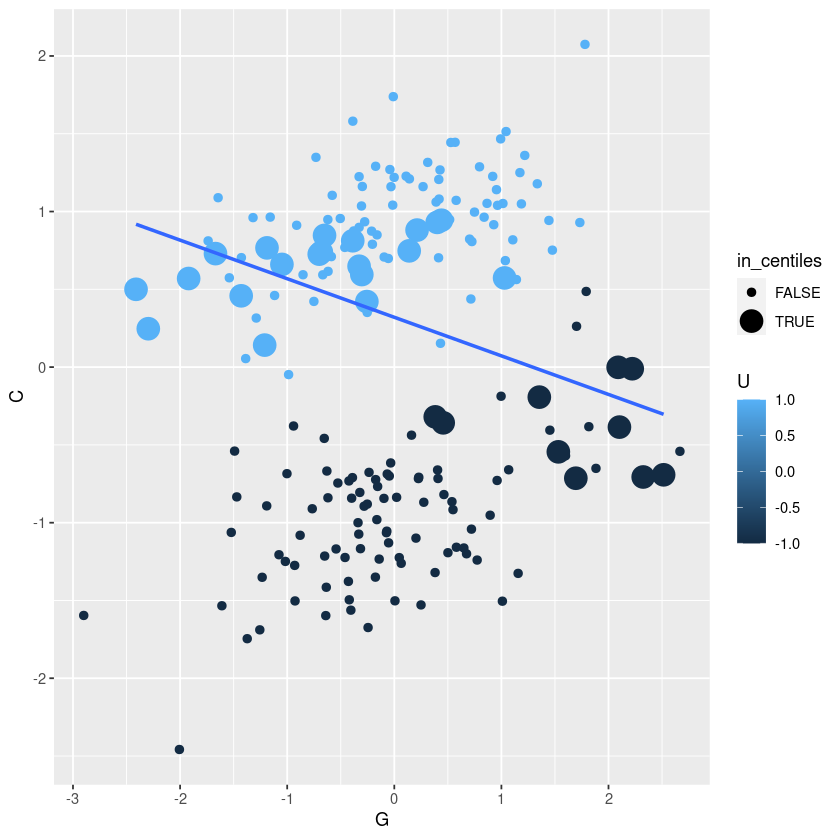

In [38]:
lower = quantile(d$P, 0.45)
upper = quantile(d$P, 0.6)
standard_d <- data.frame(
    C=standardize(d$C),
    P=standardize(d$P),
    G=standardize(d$G),
    U=d$U,
    in_centiles=d$P > lower & d$P < upper
)

ggplot(mapping=aes(G, C)) +
    geom_point(standard_d, mapping=aes(colour=U, size=in_centiles)) +
    geom_smooth(data=standard_d[standard_d$in_centiles == T,], method="lm", se=F, formula="y~x")

So here we have the results. The black cloud are children in bad neighbourhoods, and the blue are good ones. The large circles are the ones with parents in the 45th - 60th percentile. The actual percentile is largely irrelevant - it's just that conditioning on the parents is like looking at identical subpopulations,so this makes it clearer. The linear fit is for the ones in that percentile.

Why does this association exist?

Once we know $P$, learning $G$ tells us something about the neighbourhood $U$, and that is associated with the outcome.

Consider two different parent, say at at the median 50th percentile. One has a poorly educated grandparent and the other has a well educated one. In our example, the most probable way for tht to happen is if they live in different neighbourhoods - the one with a highly educated grandparent would have to live in a bad nieghbourhood to 'counteract' the effect of good grandparents, while the one with a poorly educated grandparent would need to live in a 'good' neighbourhood to counterac the negative effects of their grandparent. If that's the case, the the one with the highly educated grandparent (and living in a bad neighbourhood) will probably have a poor quality child, because of the neighbourhood. Similarly, the one with the poorly educated grandparent (and living in a good neighbourhood) will probably have a good quality child (because of the neighbourhood). Thus, we get the association that we see.

The unmeasured $U$ makes $P$ a collider, and so we have collider bias. How can we fix this? We need to account for $U$ by measuring it.

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
a,-0.12197510,0.07192588,-0.2369265,-0.007023655
b_PC,1.01161103,0.06597258,0.9061741,1.117047948
b_GC,-0.04081373,0.09728716,-0.1962974,0.114669941
b_U,1.99648992,0.14770462,1.7604294,2.232550439
sigma,1.01959911,0.05080176,0.9384081,1.100790130


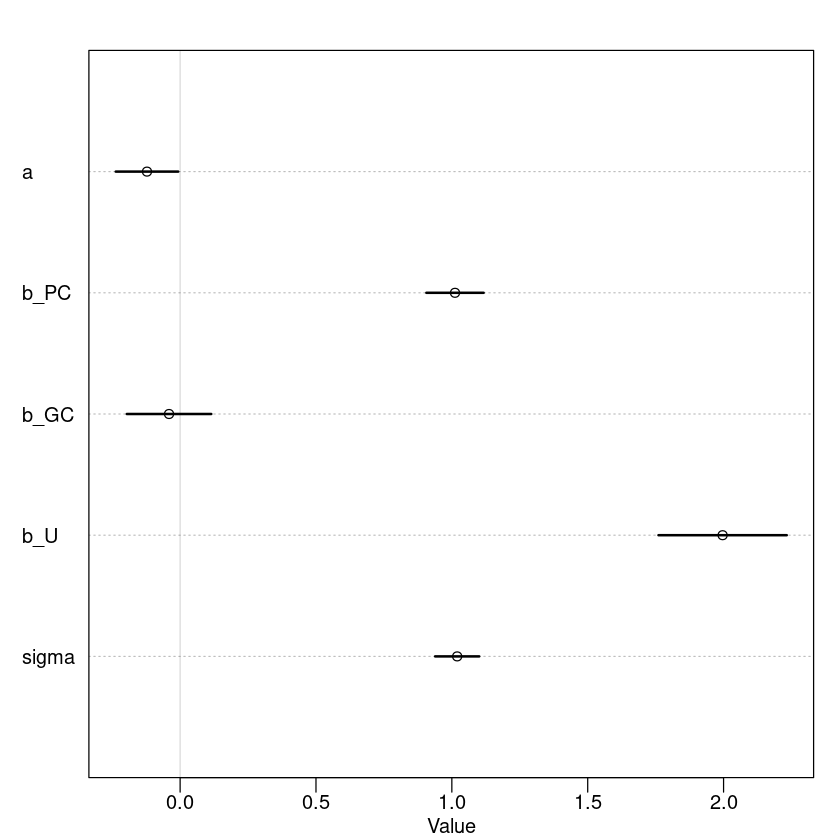

In [39]:
m6.12 <- quap(
    alist(
        C ~ dnorm(mu, sigma),
        mu <- a + b_PC * P + b_GC * G + b_U * U,
        a ~ dnorm(0, 1),
        c(b_PC, b_GC, b_U) ~ dnorm(0, 1),
        sigma ~ dexp(1)
    ),
    data=d
)
precis(m6.12)
plot(precis(m6.12))

So when we correctly condition on $U$, we get the correct results back!

---
The grandparents example is an example of Simpson's Paradox. Including another predictor, in this case P, can reverse the diretion of association between some other predictor (G, in this case) and the outcome (C). Usually, this is presenting in cases where adding the new predictor helps! In this case, it misleads. To know whether the reversal of the association reflects causation or is purely a statistical phenomenon, we need more than just the statistical model.

---

## Confronting Confounds

We have now seen examples where we can use multiple regression to account for confounding, but confusingly, we've also seen cases where multiple regression can itself cause confounding! Key lesson: don't just add everything to a model and hope that it works out!

Which principles example why sometimes, leaving out or keeping variables in can cause the same phenomenon? Are there other causal monsters lurking?

Let's define **confounding** as any context in which the association between an outcome $Y$ and a predictor $X$ is not the same as it would be if we had experimentally determined it. For instance,suppose we are interested in the association between education $E$ and wages $W$. The problem is that many things influence both - e.g. where they live, their friends, &c.

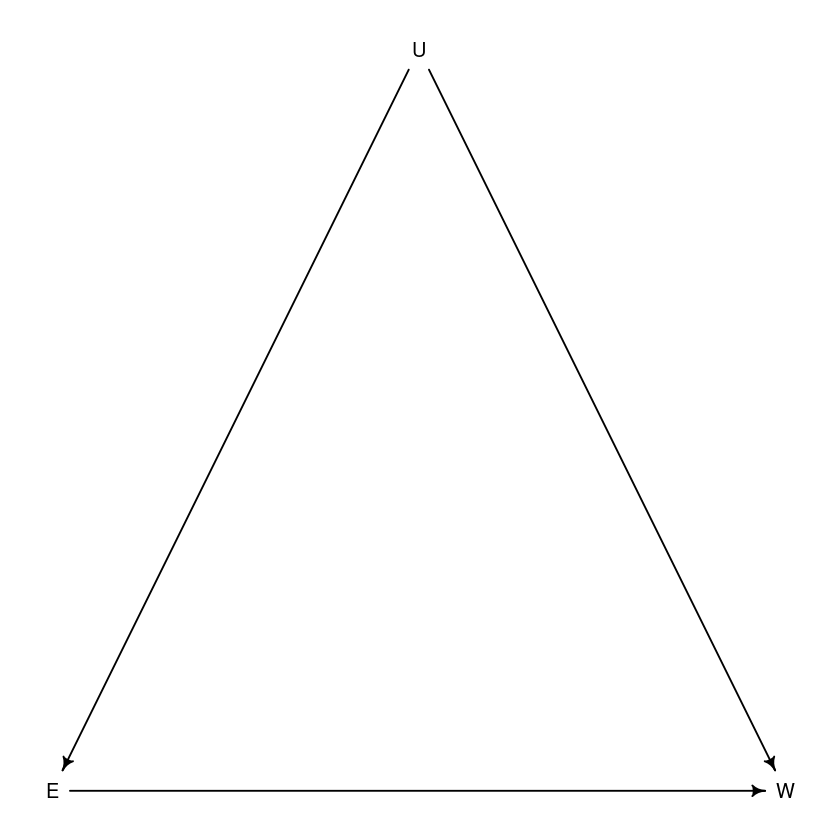

In [40]:
education_dag <- dagitty(
    'dag{
        U[pos="0,0"]
        E[pos="-0.5,0.5"]
        W[pos="0.5,0.5"]
        E <- U -> W
        E -> W
    }'
)
drawdag(education_dag)

If we regress $W$ on $E$, the estimate of the causal effect will be confounded by $U$. There are two paths from $E$ to $W$: $E \to W$ and $E \leftarrow U \to W$. A path here just means any series of variables you could walk through to get from one variable to another, ignoring the direction of the arrows. Both of these paths create a statistial association between $E$ and $W$, but only the first path is causal. 

How do we know? If *only* the second path existed, and we changed $E$, then it would not change $W$. Any causal influence of $E$ on $W$ operates only on the first path.

How can we isolate the causal path? The most samous solution to to run an experiment. If we could assign education levels ar random, it changes the graph:

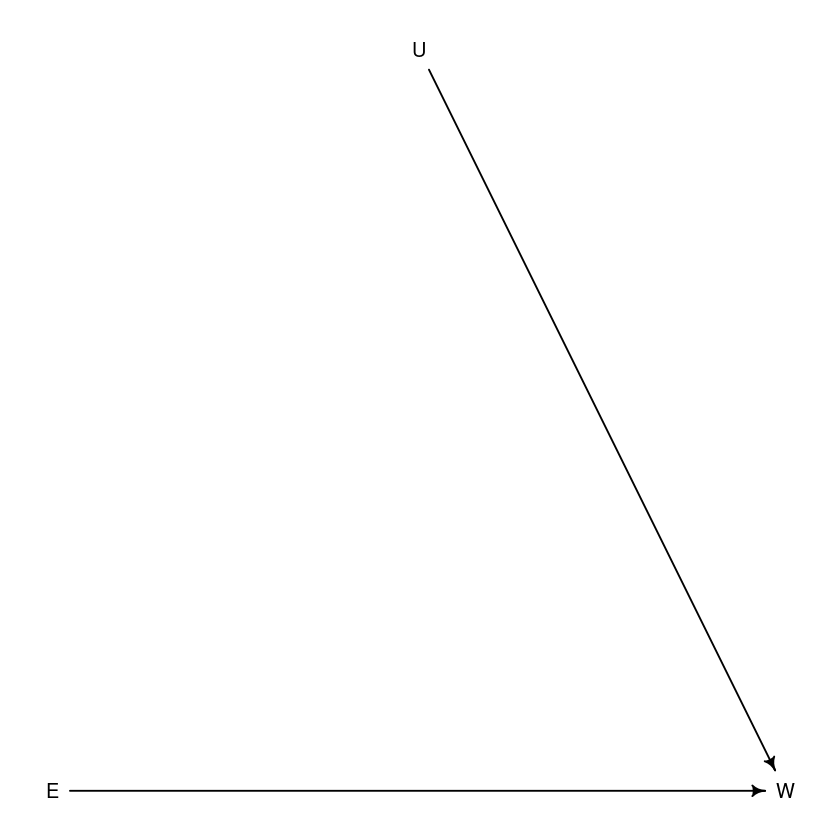

In [41]:
education_experiment_dag <- dagitty(
    'dag{
        U[pos="0,0"]
        E[pos="-0.5,0.5"]
        W[pos="0.5,0.5"]
        U -> W
        E -> W
    }'
)
drawdag(education_experiment_dag)

Manipulation removes the influence of $U$ on $E$. The unobserved variables don't influence the level of education - we do that through the manipulation. This blocks the second path. Now there is only one way for information to go between $E$ and $W$, and so measuring that gives us a meaningful measure of causal influence.

Of course, this can be difficult. There's another way - controlling for the unobserved variable $U$. This also bloks the flow of information between $E$ and $W$ through $U$.

Why? Because it makes $EE$ and $W$ independent, *conditional on $U$*.

### Shutting the backdoor

Blocking confounding paths between some predictor $X$ and an outcome $Y$ is known as **shutting the backdoor**. We don't want any suprious associations sneakig in through a non-causal path that enters the back of the predictor $X$. In teh example above, $E \leftarrow U \to W$ is a backdoor path because it enters $E$ with an arrowand also connects $E$ to $W$. This path is non-causal - intervening on $E$ will no cause a change in $W$ through this path - but it will still cause an association between $E$ and $W$.

Good news! Given a causal DAG, we can always say which variables we need to condition on, and just as importantly, we can always say which ones we *shouldn't* condition on in order to avoid making new confounds.

There are really only four different things we need to worry about:

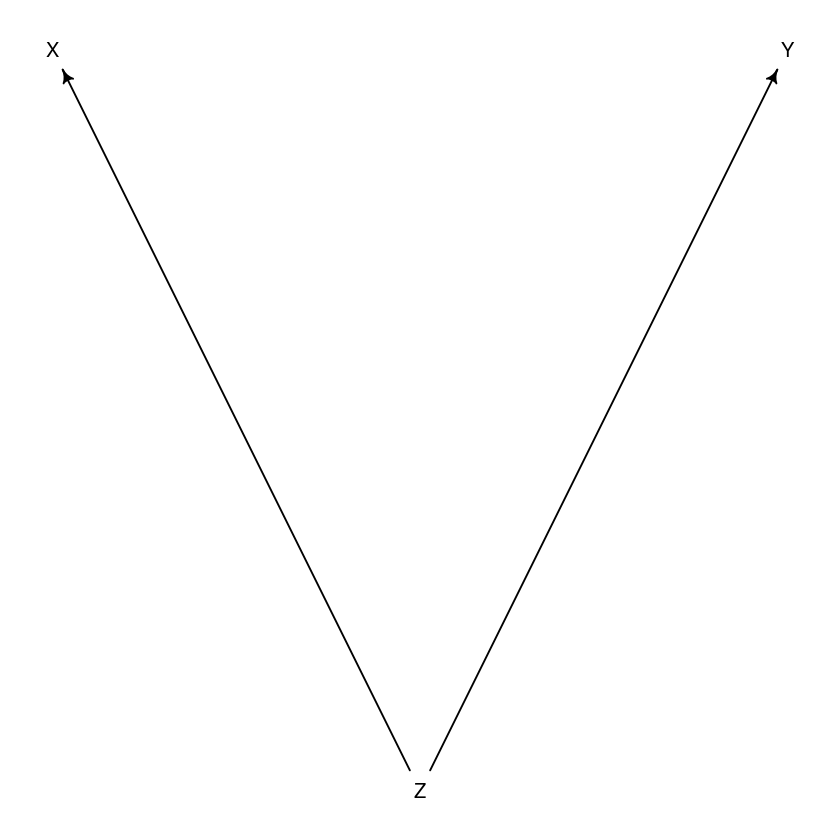

In [42]:
fork <- dagitty('dag{
    Z[pos="0,0"]
    X[pos="-0.5,-0.5"]
    Y[pos="0.5,-0.5"]
    X <- Z -> Y
}')
drawdag(fork)

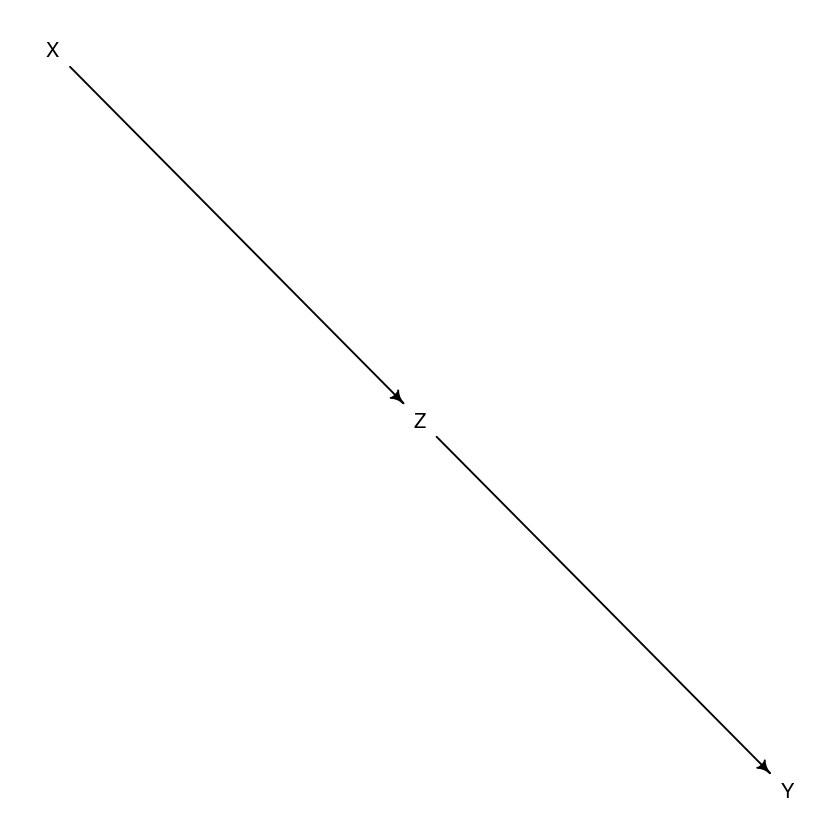

In [43]:
pipe <- dagitty('dag{
    Z[pos="0,0"]
    X[pos="-0.5,-0.5"]
    Y[pos="0.5,0.5"]
    X -> Z -> Y
}')
drawdag(pipe)

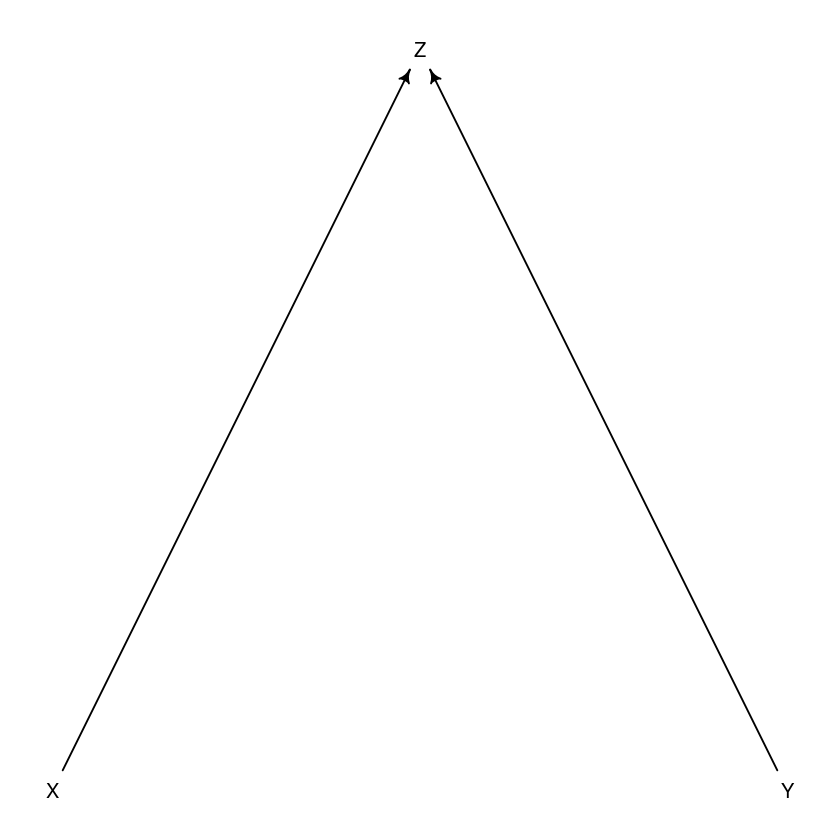

In [44]:
collider <- dagitty('dag{
    Z[pos="0,0"]
    X[pos="-0.5,0.5"]
    Y[pos="0.5,0.5"]
    X -> Z
    Y -> Z
}')
drawdag(collider)

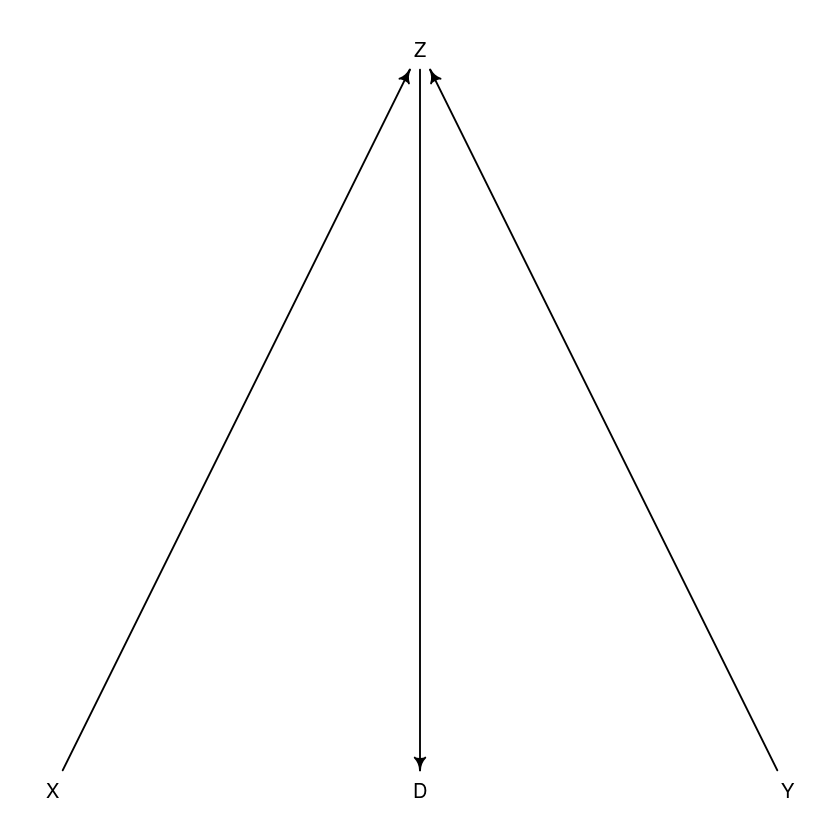

In [45]:
descendant <- dagitty('dag{
    Z[pos="0,0"]
    X[pos="-0.5,0.5"]
    Y[pos="0.5,0.5"]
    D[pos="0,0.5"]
    X -> Z
    Y -> Z
    Z -> D
}')
drawdag(descendant)

Every DAG, no matter how complicated, is built out of these four.

1. Fork: Classic confounder. Here, some variable $Z$ is the common cause of both $X$ and $Y$. $X$ and $Y$ are independent, conditional on $Z$.
1. Pipe: E.g. the plant growth example with a post-treatment effect. The treatment $X$ influences the fungus $Z$ which influences growth $Y$. If we condition on $Z$, we block the path from $X$ to $Y$. So in both a fork and a pipe, condition on the middle variables blocks the path.
1. Collider: $X \to Z \leftarrow Y$. Unlike other types of relations, there is no association between $X$ and $Y$ until you condition on $Z$. Conditioning on $Z$, the collider variable, opens the path. Once the path is open, information flows between $X$ and $Y$. However, neither $X$ nor $Y$ has any causal influence on the other.
1. Descendant: Variable influenced by another variable. Condition on a descendant partly conditions on its parent. In the DAG, conditioning on $D$ also conditions (partially) on $Z$. $D$ has some information about $Z$. In this example, this will partially open a path from $X$ to $Y$ because $Z$ is a collider. In feneral, the consequence of conditioning on a descendant depends upon the nature of its parent. Descendants are common, because we often cannot measure a variable directly and instead just measure some proxy.

Since you can always open / close a connection, you can figure out which ones you need to open / close:
1. List all of the paths connecting $X$ (the potential cause) and $Y$ (the outcome)
1. Classify each path by whether it is open or closed. A pth is open unless it ontains a collider.
1. Classify each path by whether it is a backdoor path. A backdoor path has an arrow entering $X$.
1. If there are any open backdoor paths, decide which variable(s) to condition on to close it, if possible.

Some examples:

### Two Roads

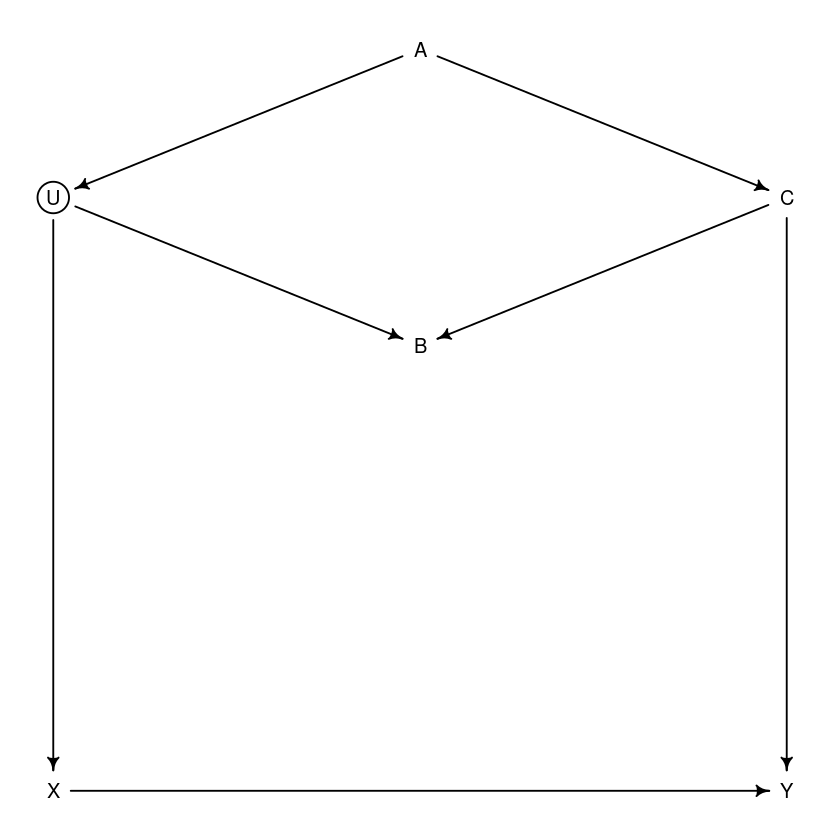

In [46]:
two_roads_dag <- dagitty('dag{
    U[unobserved,pos="-1,0"]
    A[pos="0,-0.25"]
    B[pos="0,0.25"]
    C[pos="1,0"]
    X[pos="-1,1"]
    Y[pos="1,1"]
    U -> X -> Y
    U <- A -> C
    U -> B
    C -> B
    C -> Y
}')
drawdag(two_roads_dag)

So here we have an exposure of interest ($X$), and outcome of interest ($Y$), an unobserved variable $U$, and three observed covariates, $A$, $B$, and $C$.

We are interested in the effect of $X$ on $Y$. Which of these do we need to add to the model to correctly infer it? To figure this out, look for backdoor paths. Apart from the direct one, there are two paths from $X$ to $Y$ (recall that we can go 'backwards' down a path):
1. $X \leftarrow U \leftarrow A \to C \to Y$
1. $X \leftarrow U \to B \leftarrow C \to Y$

These are both backdoor paths (they enter $X$). We now need to decide which of these paths are open and close them if they are. If they're closed, we need to ensure that we don't accidentally open them. Recall that a path is open unless it contains a collider.

Consider the first path, passing through $A$. It is open, since there is no collider. It's a fork at the top, and then two pipes. To close this, we need to condition on one of the variables. We can't condition on $U$ (it's unobserved) - thus, we need to condition on either $A$ or $C$. Either would work, but conditioning on $C$ is the better idea since (apparently) it would help with the precision of the estimate of $X \to Y$.

Also, we can get `dagitty` to do this for us:

In [47]:
adjustmentSets(two_roads_dag, exposure="X", outcome="Y")

{ C }
{ A }

The second path contains a collider, and so is already closed. We don't need to condition on $B$. In fact, if we do we open up the flow of information and will create misleading results.

### Backdoor Waffles
Let's return to the Waffle House and divorce rate correlation from Chapter 5. We'll make a DAG, use it to find a minimal set of covariates, and derive the testable implications of the DAG. This is important, because sometimes you really can test whether your DAG is consistent with the evidence.

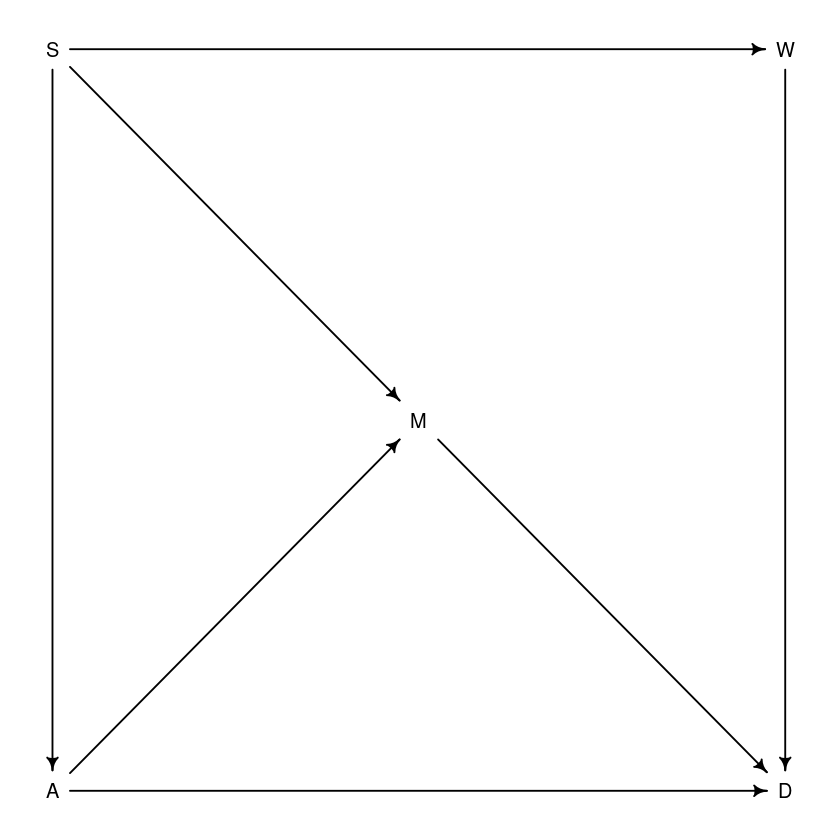

In [48]:
waffle_dag <- dagitty('dag{
    S[pos="0,0"]
    W[pos="1,0"]
    D[pos="1,1"]
    M[pos="0.5,0.5"]
    A[pos="0,1"]
    D <- W <- S -> A -> D
    S -> M <- A
    M -> D
}')
drawdag(waffle_dag)

- $S$: whether it's a Southern state
- $A$: median age at marriage
- $M$: marriage rate
- $W$: number of Waffle Houses
- $D$: Divorce rate

There are three open backdoor paths from $W$ to $D$. All of them pass through $S$, so we can close them all by conditioning on $S$. Confirming:

In [49]:
adjustmentSets(waffle_dag, exposure="W", outcome="D")

{ A, M }
{ S }

So we can either condition on $S$ or on both of $A$ and $M$.

This DAG is probably not correct - it assumes that there are no unobserved variables, for instance. Now we can examine the conditional independencies. Although they won't tell us if the AG is correct, they can tell us if it's wrong and give us some hints as to how.

Recall: conditional independencies are paris of variables that are not associated, once we condition on some other set of variables.

You can find the conditional independencies using the same path logic as for finding the backdoor paths. You focus on a pair of variables, find all paths connecting them, and figure out if there is a set of variables you could condition on to close all of them. It's tedious, but possible. Luckily, the computer can do it for us!

In [50]:
impliedConditionalIndependencies(waffle_dag)

A _||_ W | S
D _||_ S | A, M, W
M _||_ W | S

## Practice

### Easy

**6E1** List three mechanisms by which multiple regression can produce false inference about causal effects

1. Multicollinearity: when the structure of the model is such that two variables are highly associated (conditional on the other variables in the model), their possible values will live on a line. This will make it seem that neither is strongly associated with the outcome, even if in reality they both (or all) are.
1. Post-treatment effects: When you condition on a post-treatment effect, you can remove the effect of the treatment (since if the post-treatment effect causes the effect, then once you know it, knowing about the treatment itself is largely superfluous).
1. Collider bias: A collider is a node on a DAG where two arrows enter it. If you condition on the collider, then you are creating a statistical (not necessarily causal) association between the nodes entering the collider.

**6E2** For one of the mechanisms in the previous problem, provide an example of your choice, perhaps from your research.

E.g. the fact that so many fossils are found near pubs. This is probably due to multicollinearity - because both the presence of pubs and the presence of paleontologists are both associatd with a larger population, there's a (probably) false association being created.

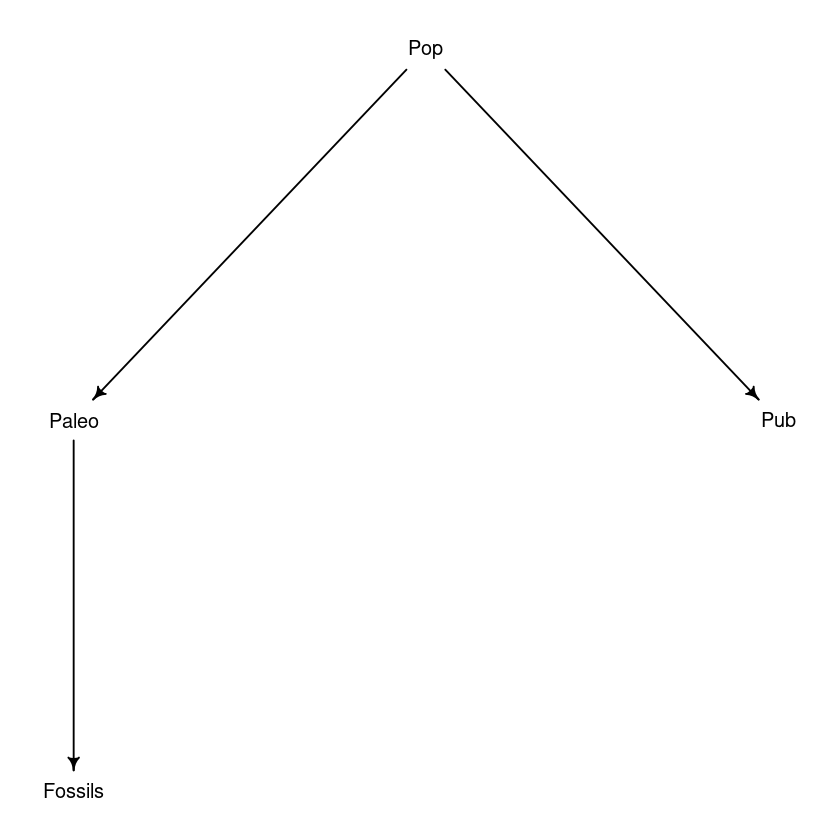

In [51]:
paleo_dag <- dagitty('dag{
    Pop[pos="0,0"]
    Pub[pos="1,1"]
    Paleo[pos="-1,1"]
    Fossils[pos="-1,2"]
    Pub <- Pop -> Paleo
    Paleo -> Fossils
}')
drawdag(paleo_dag)

**6E3** List the four elemental confounds. Can you explain the conditional independencies of each?

1. Fork: $X \leftarrow Z \to Y$. The conditional independencies are $X \perp Y | Z$.

In [52]:
fork <- dagitty('dag{X <- Z -> Y}')
impliedConditionalIndependencies(fork)

X _||_ Y | Z

2. Pipe: $X \to Z \to Y$. The conditional independencies are $X \perp Y | Z$

In [53]:
pipe <- dagitty('dag{X -> Z -> Y}')
impliedConditionalIndependencies(pipe)

X _||_ Y | Z

3. Collider: $X \to Z \leftarrow Y$. The conditional independencies are $X \perp Y$. There is only an association if we create one by conditioning on the collider.

In [54]:
collider <- dagitty('dag{X -> Z <- Y}')
impliedConditionalIndependencies(collider)

X _||_ Y

4. Descendant: $X \to Z \leftarrow Y; Z \to D$. The implied conditional independencies are $D \perp X,Y | Z$; $X \perp Y$

In [55]:
descendant <- dagitty('dag{X -> Z <- Y; Z -> D}')
impliedConditionalIndependencies(descendant)

D _||_ X | Z
D _||_ Y | Z
X _||_ Y

**6E4** How is a biased sample like conditioning on a collider? Think of the example at the open of the chapter.

From the example at the beginning of the chapter, we have the following:

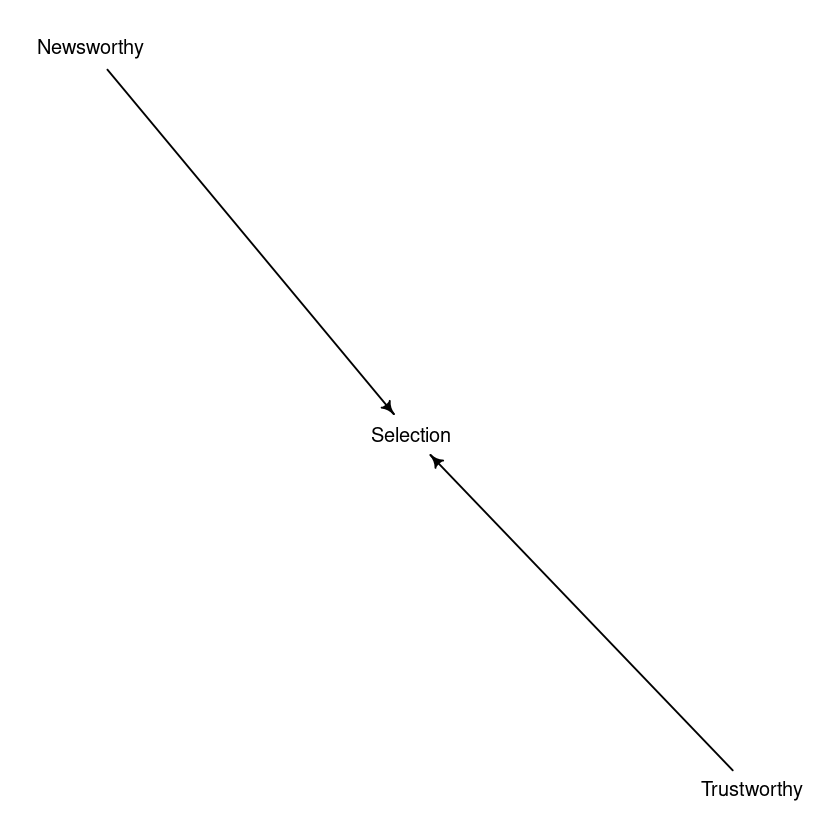

In [56]:
papers_dag <- dagitty('dag{Newsworthy -> Selection <- Trustworthy}')
drawdag(papers_dag)

When we looked only at the selected papers (a biased sample), we found an association between NW and TW, but only because of the collider bias. 

### Medium

**6M1** Modify the DAG on page 186 to include the variable $V$, an unobserved cause of $C$ and $Y$: $C \leftarrow V \to Y$. Reanalyze the DAG. How many paths from $X$ to $Y$? Which must be closed? Which variables should you condition on now?

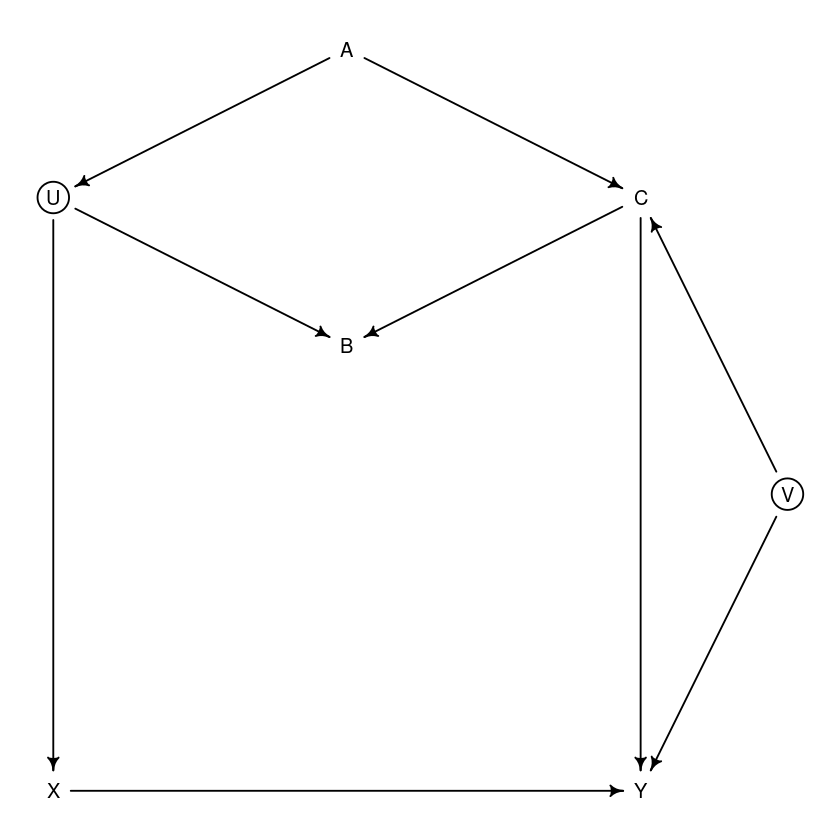

In [57]:
two_roads_dag.2 <- dagitty('dag{
    U[unobserved,pos="-1,0"]
    A[pos="0,-0.25"]
    B[pos="0,0.25"]
    C[pos="1,0"]
    X[pos="-1,1"]
    Y[pos="1,1"]
    V[unobserved, pos="1.5,0.5"]
    U -> X -> Y
    U <- A -> C
    U -> B
    C -> B
    C -> Y
    C <- V -> Y
}')
drawdag(two_roads_dag.2)

Paths from $X$ to $Y$:
1. $X \to Y$ (direct)
1. $X \leftarrow U \to B \leftarrow C \to Y$ - closed ($B$ is a collider)
1. $X \leftarrow U \leftarrow A \to C \to Y$ - open (NB: when you are deciding whether something is a collider, you *only* consider the path you are currently looking at)
1. $X \leftarrow U \to B \leftarrow C \leftarrow V \to Y$ ($B$ is a colliders)
1. $X \leftarrow U \leftarrow A \to C \leftarrow V \to Y$ ($C$ is a collider)

The only open path is $X \leftarrow U \leftarrow A \to C \to Y$. We could condition on $A$ or $C$, but since $C$ is a collider conditioning on that would be a bad idea - it would create a confound. Hence, we condition on $A$.

In [58]:
adjustmentSets(two_roads_dag.2, exposure="X", outcome="Y")

{ A }

**6M2** Sometimes, in order to avoid multicollinearity, people inspect pairwise correlations among predictors before including them in a model. This is a bad procedure, because what matters is the conditional association, not the association before the variables are included in the mode. To highlight this, consider the DAG $X \to Z \to Y$. Simulate data from this DAG so that the correlation between $X$ and $Z$ is very large. Then include both in a model predicting $Y$. Do you observe any multicollinearity? Why or why not? What is different from the legs example in the chapter?

In [59]:
NUM_SAMPLES = 200
x <- rnorm(NUM_SAMPLES, 0, 1)
z <- rnorm(NUM_SAMPLES, x, 0.5)
cor(x, z)

[1] 0.8757309

In [60]:
y <- rnorm(NUM_SAMPLES, z, 1)

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
a,0.01822537,0.06824234,-0.09083907,0.1272898
bx,0.16038814,0.13160044,-0.04993478,0.3707111
bz,0.81633021,0.12141901,0.62227919,1.0103812
sigma,0.96987204,0.04834262,0.89261119,1.0471329


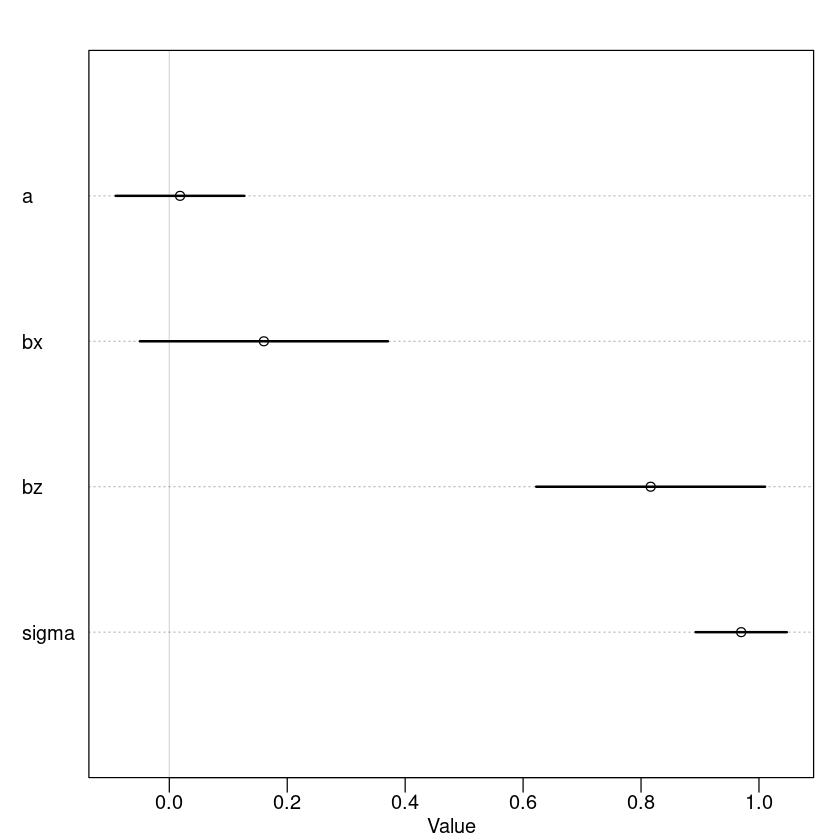

In [61]:
d <- data.frame(x=x, y=y, z=z)
m6m2.1 <- quap(
    alist(
        y ~ dnorm(mu, sigma),
        mu <- a + bx * x + bz * z,
        a ~ dnorm(0, 0.5),
        c(bx, bz) ~ dnorm(0.5, 0.5),
        sigma ~ dexp(1)
    ),
    data=d
)
precis(m6m2.1)
plot(precis(m6m2.1))

In [62]:
posterior <- extract.samples(m6m2.1)
head(posterior)

,a,bx,bz,sigma
,<dbl>,<dbl>,<dbl>,<dbl>
1,0.06523533,0.19667165,0.7766456,0.9635038
2,-0.06094282,0.10306101,0.7146512,0.9273719
3,0.03538855,0.01390227,0.9518794,0.9833684
4,-0.03476944,0.28726592,0.6151034,0.9879891
5,0.06348060,0.03023345,0.9499184,0.9684538
6,0.01432521,0.25501639,0.8317046,1.0665768


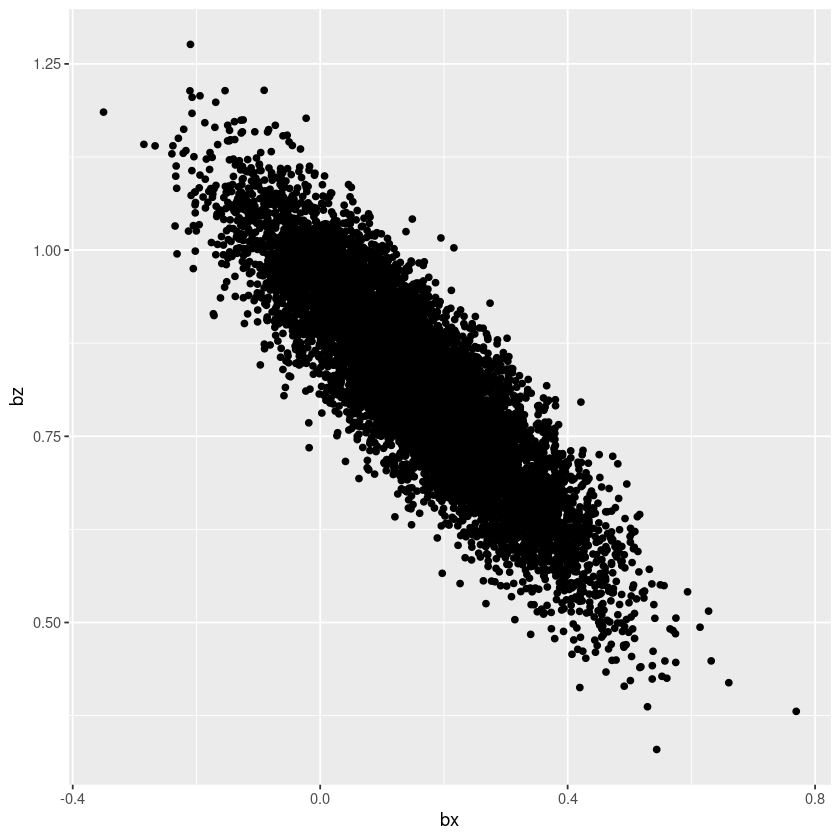

In [63]:
ggplot(posterior, aes(bx, bz)) + geom_point()

Running the model, we get basically the corect values for `bx` and `bz` back. Looking at the posterior plot of `bx` and `bz`, we do not see evidence of multicollinearity - although there is a clear link, all of the values do not lie along a narrow ridge.

Despite the high correlation between `x` and `z`, we do not see multicollinearity here because the flow of information is $X \to Z \to Y$ - that is, there is no direct effect of $X$ on $Y$. All of the information flows through $Z$. As such, we are not running into the problem of $X$ and $Z$ being tightly coupled in the sense of a combination of different values (say, adding to some value) influencing the result.

In the legs example, there was a common cause for both leg lengths - `leg_prop`. This meant that essentially the same information was present in both. However, here there is no common cause between $X$ and $Z$.

**6M3** Learning to analyze DAGs requires practice. For each of the following, state which variables, if any, you must adjust for (condition on) to estimate the total causal influence of $X$ on $Y$.

NB: this is looking for the *total causal influence*, not just the direct influence. That means that we want to keep all of the causal routes from $X$ to $Y$ open, not just the direct one.

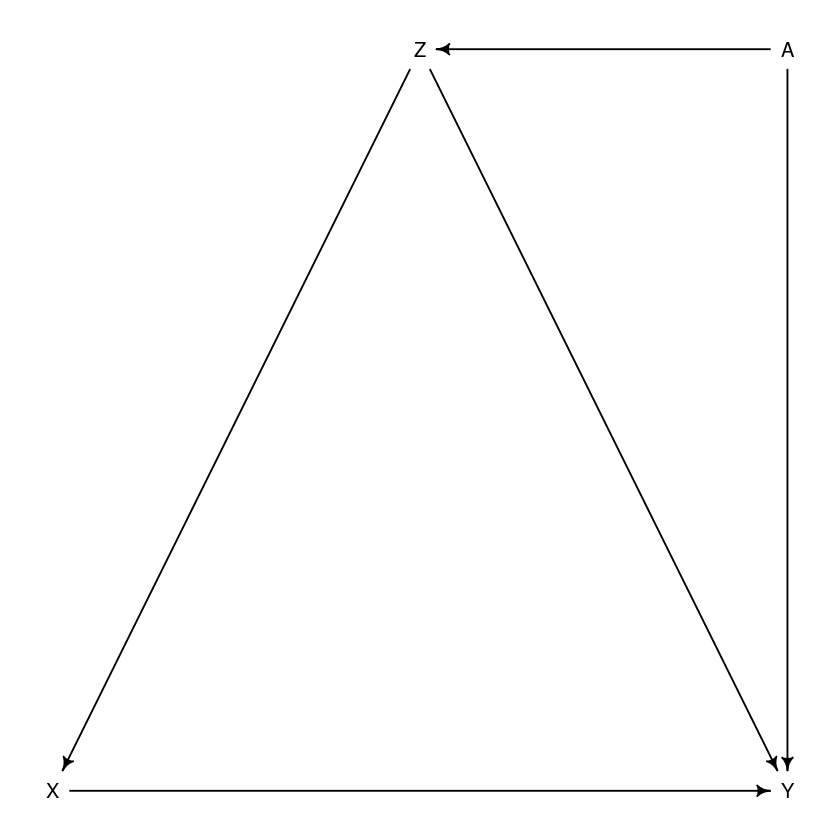

In [64]:
dag6m3.1 <- dagitty('dag{
    A[pos="0,0"]
    X[pos="-1,1"]
    Y[pos="0,1"]
    Z[pos="-0.5,0"]
    Z <- A -> Y
    X <- Z -> Y
    X -> Y
}')
drawdag(dag6m3.1)

1. $X \leftarrow Z \to Y$: open
1. $X \leftarrow Z \leftarrow A \to Y$: open
close both paths by conditioning on $Z$.

In [65]:
adjustmentSets(dag6m3.1, exposure="X", outcome="Y")

{ Z }

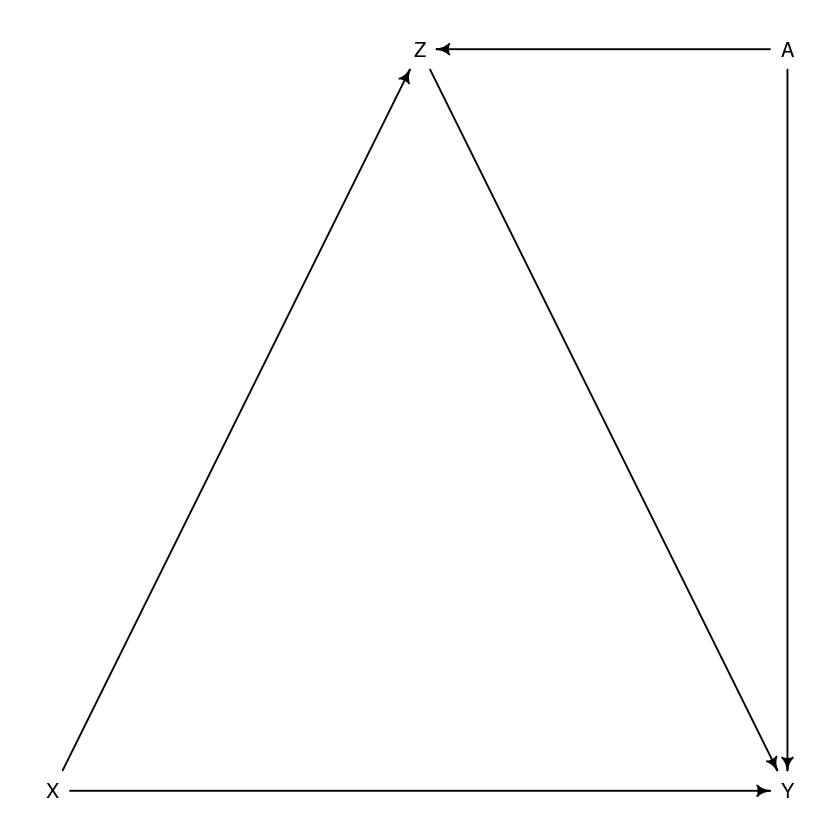

In [66]:
dag6m3.2 <- dagitty('dag{
    A[pos="0,0"]
    X[pos="-1,1"]
    Y[pos="0,1"]
    Z[pos="-0.5,0"]
    Z <- A -> Y
    X -> Z -> Y
    X -> Y
}')
drawdag(dag6m3.2)

1. $X \to Z \to Y$: open
1. $X \to Z \leftarrow A \to Y$: closed ($Z$ is a collider)

Here, there is one open path, but closing it by conditioning on $Y$ would lead to collider bias. We don't condition on anything (but there's still an open path). That's OK, because it's causal.

In [67]:
adjustmentSets(dag6m3.2, exposure="X", outcome="Y")

 {}

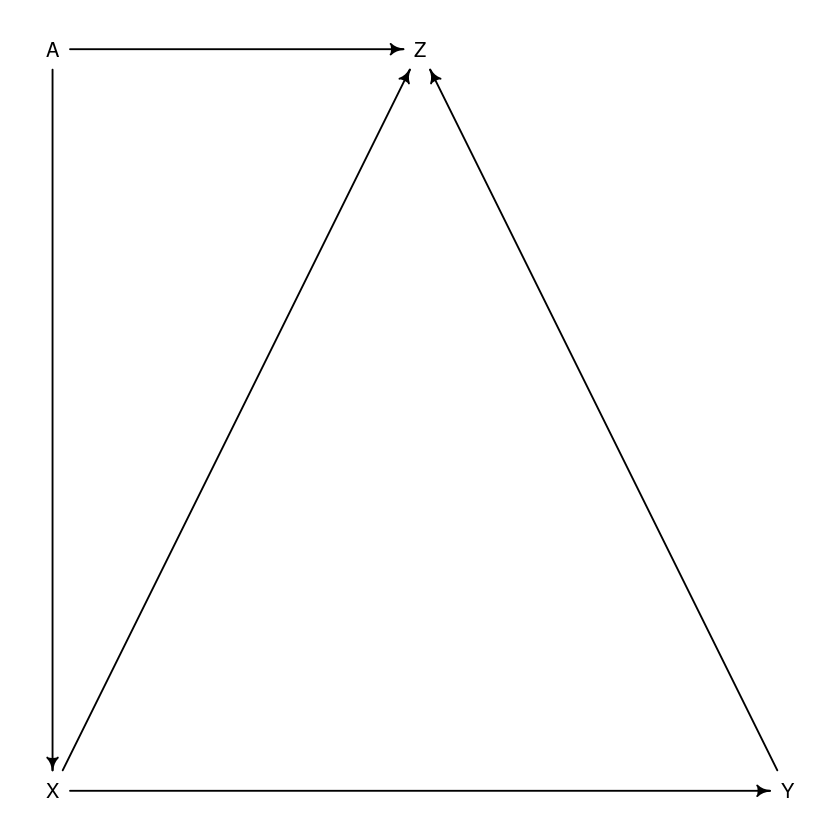

In [68]:
dag6m3.3 <- dagitty('dag{
    A[pos="0,0"]
    X[pos="0,1"]
    Y[pos="1,1"]
    Z[pos="0.5,0"]
    Z <- A -> X
    X -> Z <- Y
    X -> Y
}')
drawdag(dag6m3.3)

1. $X \leftarrow A \to Z \leftarrow Y$: closed
1. $X \to Z \leftarrow Y$: closed

No open paths - we don't adjust on anything.

In [69]:
adjustmentSets(dag6m3.3, exposure="X", outcome="Y")

 {}

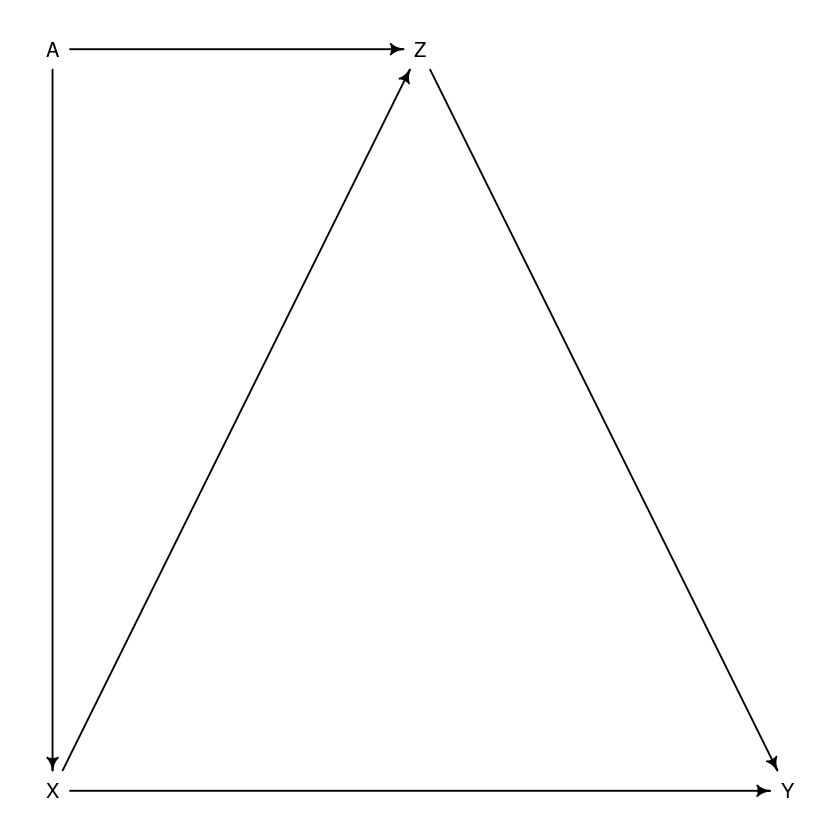

In [70]:
dag6m3.4 <- dagitty('dag{
    A[pos="0,0"]
    X[pos="0,1"]
    Y[pos="1,1"]
    Z[pos="0.5,0"]
    Z <- A -> X
    X -> Z -> Y
    X -> Y
}')
drawdag(dag6m3.4)

1. $X \leftarrow A \to Z \to Y$: open
1. $X \to Z \to Y$: open (but we want it)

We close the open non-causal path by conditioning on $A$.

In [71]:
adjustmentSets(dag6m3.4, exposure="X", outcome="Y")

{ A }

### Hard

**6H1** Use the Waffle House data, `data(WaffleDivorce)`, to find the total causal influence of number of Waffle Houses on divorce rate. Justify your model or models with a causal graph.

In [72]:
data(WaffleDivorce)
d <- WaffleDivorce
head(d)

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage.SE,Divorce,Divorce.SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860
,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<dbl>
1,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45
2,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00
3,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00
4,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26
5,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00
6,Colorado,CO,5.03,25.7,23.5,1.24,11.6,0.94,11,0,0,34277,0.00


We'll use the DAG from before:

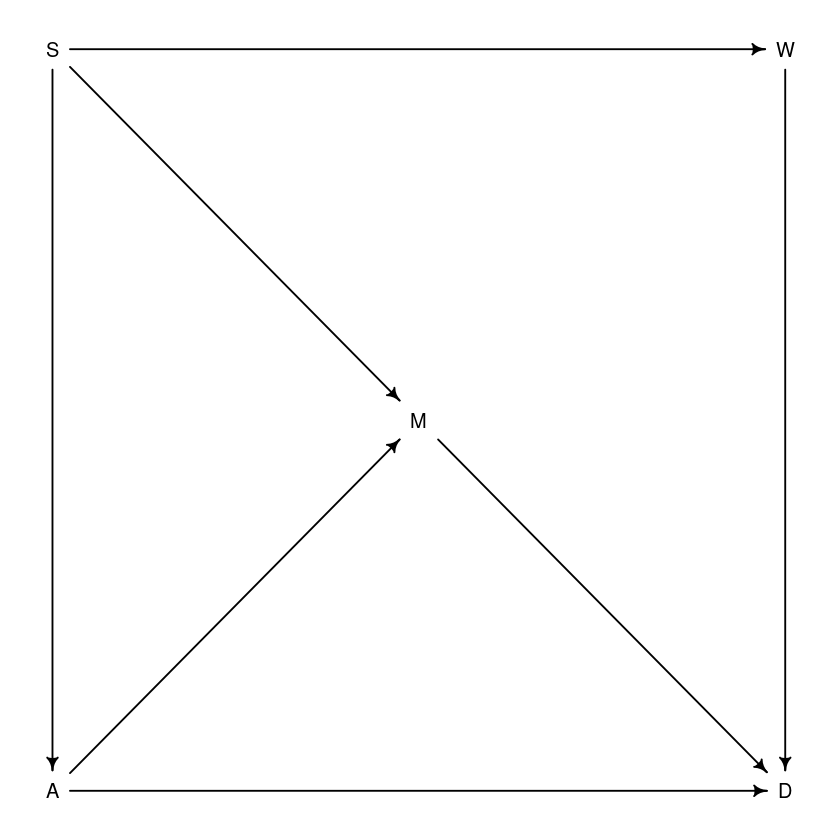

In [73]:
drawdag(waffle_dag)

There's only one causal path from $W$ to $D$, the direct one. Thus, we need to close all of backdoor ones. Luckily, we can do that by conditioning on $S$.

In [74]:
adjustmentSets(waffle_dag, exposure="W", outcome="D")

{ A, M }
{ S }

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
bM,-0.07656569,0.15717554,-0.3277626,0.1746312
bA,-0.60571526,0.16193595,-0.8645202,-0.3469103
bW,0.08961127,0.14826485,-0.1473446,0.3265671
bS[1],-0.08588620,0.14271588,-0.3139737,0.1422013
bS[2],0.21951617,0.26428490,-0.2028621,0.6418945
sigma,0.75785421,0.07493773,0.6380892,0.8776192


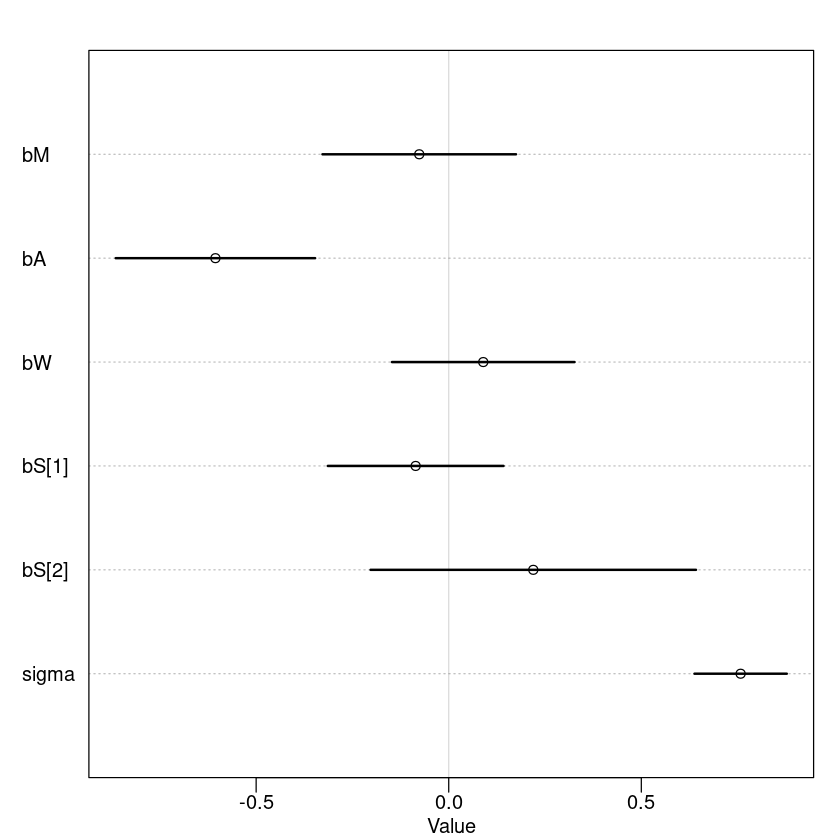

In [75]:
d$S <- ifelse(d$South == 1, 2, 1)
d$M <- standardize(d$Marriage)
d$A <- standardize(d$MedianAgeMarriage)
d$W <- standardize(d$WaffleHouses)
d$D <- standardize(d$Divorce)

# now to actually build the model
m6h1 <- quap(
    alist(
        D ~ dnorm(mu, sigma),
        mu <- bM * M + bA * A + bW * W + bS[S],
        bM ~ dnorm(0, 2),
        bA ~ dnorm(0, 2),
        bW ~ dnorm(0, 2),
        bS[S] ~ dnorm(0, 2),
        # c(a, bM, bA, bS[S]) <- dnorm(0, 2),
        sigma ~ dexp(1)
    ),
    data=d
)
precis(m6h1, depth=2)
plot(precis(m6h1, depth=2))

From this, we conclude that number of waffle houses has little effect on the divorce rate.

**6H2** Build a series of models to test the implied conditional independencies of the causal graph you used in the previous problem. If any of the tests fail, how do you think the graph needs to be amended? Does the graph need more or fewer arrows? Feel free to nominate vaiables that aren't in the data.

In [76]:
impliedConditionalIndependencies(waffle_dag)

A _||_ W | S
D _||_ S | A, M, W
M _||_ W | S

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
bS[1],0.15183694,0.16370208,-0.1097906,0.41346448
bS[2],-0.34145055,0.26804822,-0.7698434,0.08694228
bW,0.03282534,0.16422989,-0.2296457,0.29529642
sigma,0.94979480,0.09396226,0.7996250,1.09996463


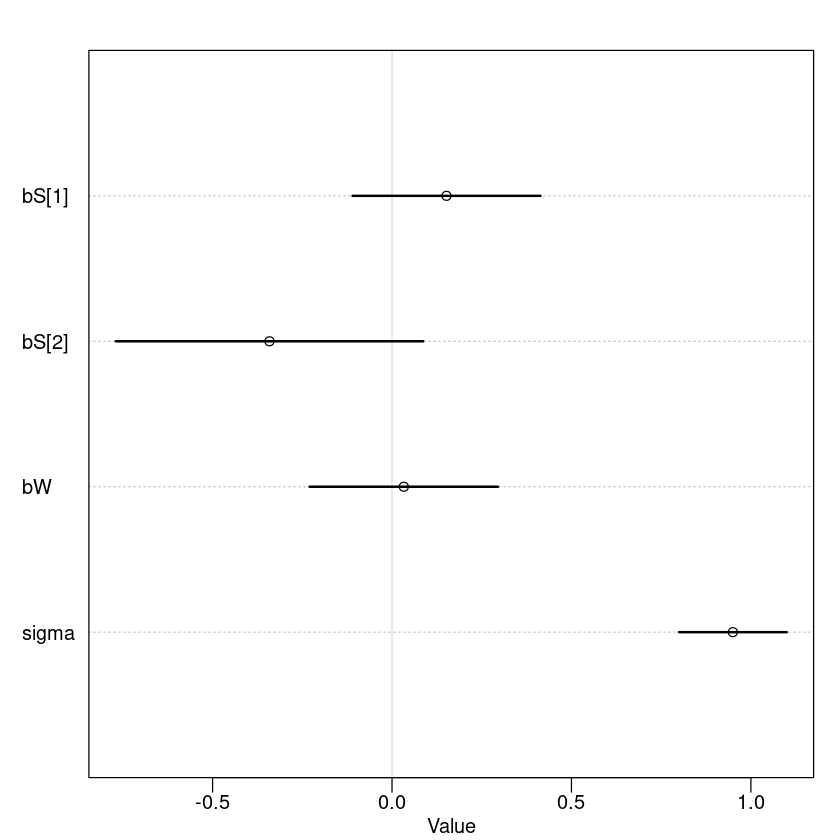

In [77]:
# A independent of W given S
m6h2.1 <- quap(
    alist(
        A ~ dnorm(mu, sigma),
        mu <- bS[S] + bW * W,
        bS[S] ~ dnorm(0, 0.5),
        bW ~ dnorm(0, 0.5),
        sigma ~ dexp(1)
    ),
    data=d
)
precis(m6h2.1, depth=2)
plot(precis(m6h2.1, depth=2))

So this one checks out.

D independent of S given A, M, W

This is actually just our full model - looking at the results, we can see that both $bS[1]$ and $bS[2]$ overlap 0 - this holds.

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
bS[1],-0.05607964,0.16760342,-0.3239423,0.2117830
bS[2],0.12533675,0.27243000,-0.3100590,0.5607325
bW,-0.02721939,0.16773219,-0.2952878,0.2408491
sigma,0.97672833,0.09632013,0.8227902,1.1306665


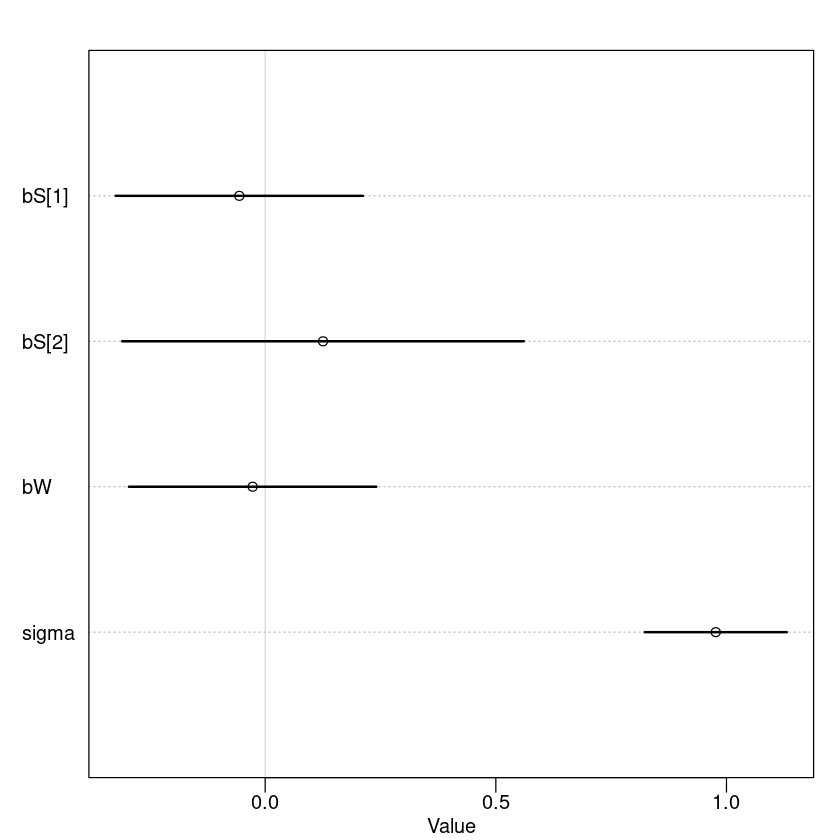

In [78]:
# M independent of W given S
m6h2.2 <- quap(
    alist(
        M ~ dnorm(mu, sigma),
        mu <- bS[S] + bW * W,
        bS[S] ~ dnorm(0, 0.5),
        bW ~ dnorm(0, 0.5),
        sigma ~ dexp(1)
    ),
    data=d
)
precis(m6h2.2, depth=2)
plot(precis(m6h2.2, depth=2))

Yes - `bW` overlaps zero. This one passes.

So it looks like all of our conditional independencies are good - we at least can't immediately rule out this causal model.

---

All three problems below are based on the same data. the data in `data(foxes)` are 116 foxes from 30 individual urban groups in England. These foxes are like street gangs. group size varies from 2 to 8 individuals. For the problems, assume the following DAG.

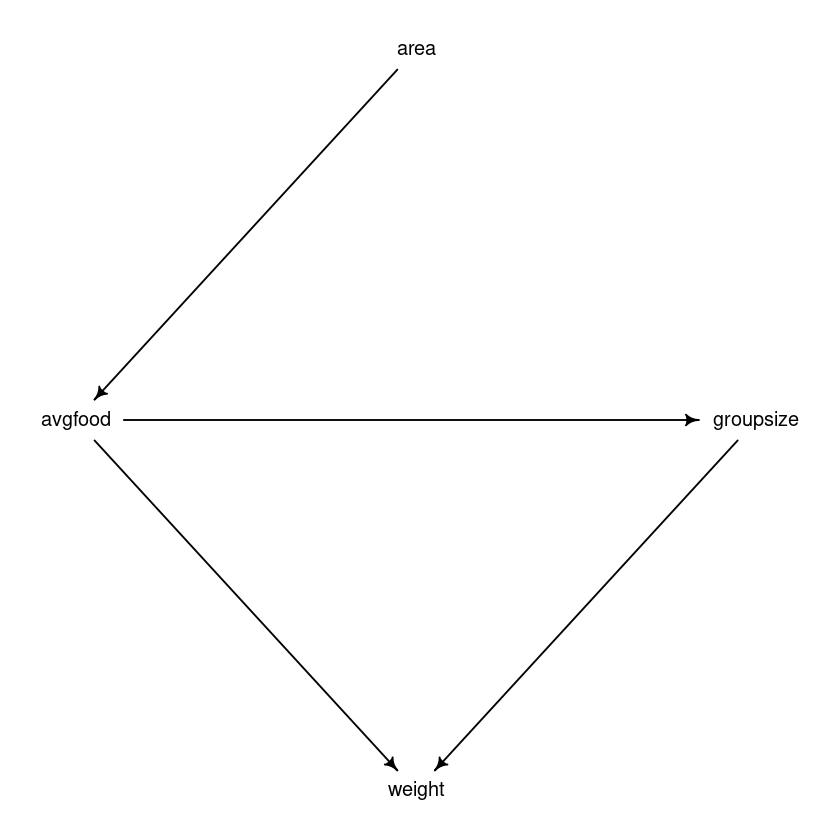

In [79]:
fox_dag <- dagitty('dag{
avgfood[pos="0,0"]
area[pos="1,-1"]
weight[pos="1,1"]
groupsize[pos="2,0"]
area -> avgfood -> groupsize -> weight <- avgfood
}')
drawdag(fox_dag)

**6H3** Use a model to infer the total causal influence of `area` on `weight`. Would increasing the area available to each fox make it heavier (healthier)? You might want to standardize the variables. Regardless, use prior predictive simulation to show that your model's prior predicions stay within the possible outcome range.

In [80]:
data(foxes)
head(foxes)

,group,avgfood,groupsize,area,weight
,<int>,<dbl>,<int>,<dbl>,<dbl>
1,1,0.37,2,1.09,5.02
2,1,0.37,2,1.09,2.84
3,2,0.53,2,2.05,5.33
4,2,0.53,2,2.05,6.07
5,3,0.49,2,2.12,5.85
6,3,0.49,2,2.12,3.25


In [81]:
d <- data.frame(
    group=foxes$group,
    AvgFood=standardize(foxes$avgfood),
    GroupSize=standardize(foxes$groupsize),
    Area=standardize(foxes$area),
    Weight=standardize(foxes$weight)
)

We want the effect of Area on Weight. There are two paths:
1. $Area \to AvgFood \to Weight$ (open)
1. $Area \to AvgFood \to GroupSize \to Weight$ (open)

Both are causal, so we want to keep them open - we won't adjust on anything.

In [82]:
adjustmentSets(fox_dag, exposure="area", outcome="weight")

 {}

In [83]:
m6h3 <- quap(
    alist(
        Weight ~ dnorm(mu, sigma),
        mu <- a + bArea * Area,
        a ~ dnorm(0, 0.5),
        bArea ~ dnorm(0, 0.5),
        sigma ~ dexp(1)
    ),
    data=d
)

In [84]:
prior <- extract.prior(m6h3)
mu <- link(m6h3, post=prior, data=list(Area=c(-2, 2)))
head(mu)

-0.90341948,1.87950680
-0.83722850,0.61509380
1.65494352,-1.40204065
-0.40983402,1.05876681
-0.05889494,-0.44293729
-0.23070091,-0.08102329


In [85]:
priors_data <- data.frame(
    x=double(),
    y=double(),
    identifier=factor()
)
for (i in 1:nrow(mu)) {
    row <- data.frame(x=c(-2,2), y=mu[i,], identifier=i)
    priors_data <- rbind(priors_data, row)
}
head(priors_data)

,x,y,identifier
,<dbl>,<dbl>,<int>
1,-2,-0.9034195,1
2,2,1.8795068,1
3,-2,-0.8372285,2
4,2,0.6150938,2
5,-2,1.6549435,3
6,2,-1.4020407,3


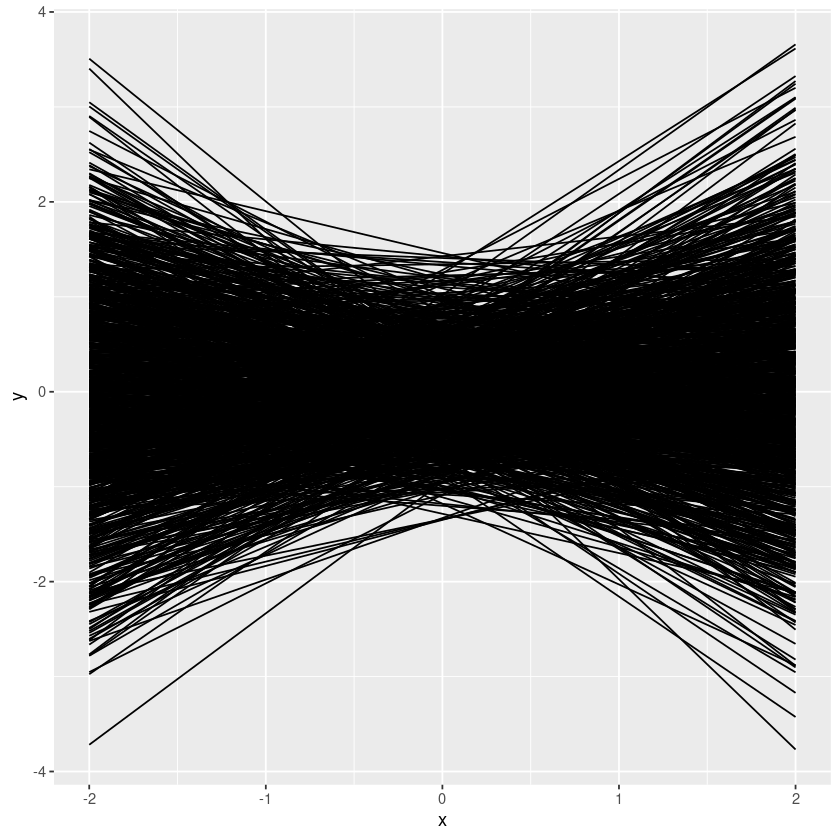

In [86]:
ggplot(priors_data, aes(x, y, group=identifier)) +
    geom_line()

So this seems roughly plausible - maybe a bit wide, but good enough.

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
a,-7.916439e-07,0.09051597,-0.1446628,0.1446612
bArea,1.883327e-02,0.09089575,-0.1264357,0.1641022
sigma,9.912653e-01,0.06466636,0.8879160,1.0946146


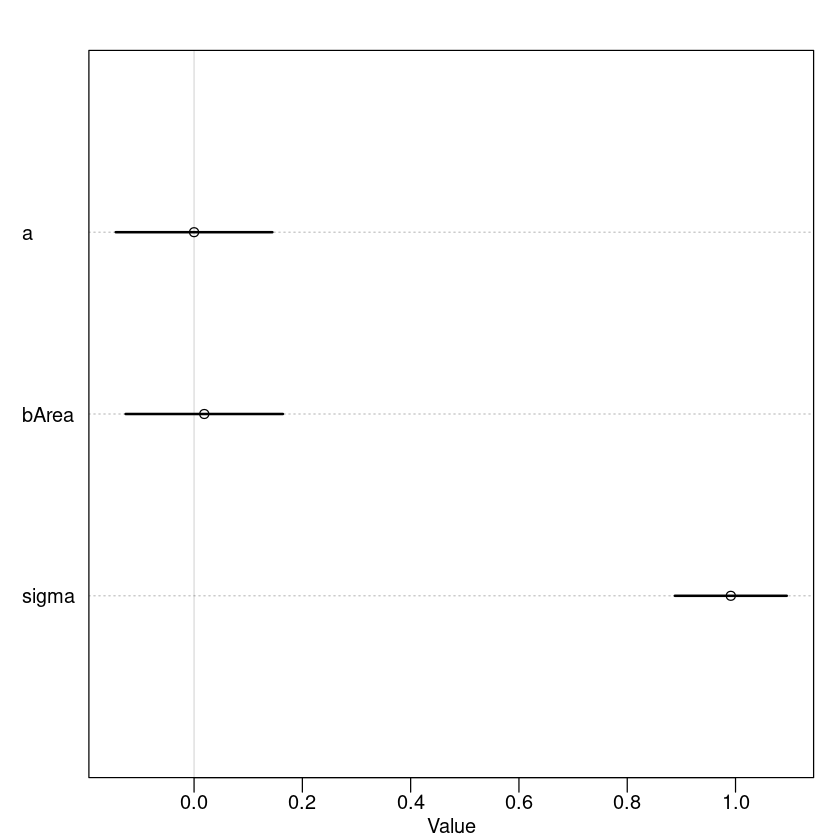

In [87]:
precis(m6h3)
plot(precis(m6h3))

So from this, it seems that the area doesn't have an impact on the weight of the foxes. Increasing the area would not be expected to increase the weight of the foxes.

**6H4** Now infer the causal impact of adding food to a territory. Would this make foxes heavier? Which covariates do you need to adjust for to estimate the total causal influence of food?

Again, all paths are open and causal - we don't need to condition on anything.

In [88]:
m6h4 <- quap(
    alist(
        Weight ~ dnorm(mu, sigma),
        mu <- a + bAvgFood * AvgFood,
        a ~ dnorm(0, 0.5),
        bAvgFood ~ dnorm(0, 0.5),
        sigma ~ dexp(1)
    ),
    data=d
)

In [89]:
prior <- extract.prior(m6h4)

In [90]:
mu <- link(m6h4, post=prior, data=list(AvgFood=c(-2,2)))
head(mu)

-0.06342902,0.2633580
2.76506749,-1.6788181
-2.07313463,1.3424437
-0.24417534,0.4980198
-0.02214290,0.8899949
1.22048331,0.7090158


In [91]:
priors_data <- data.frame(
    x=double(),
    y=double(),
    identifier=factor()
)
for (i in 1:nrow(mu)) {
    row <- data.frame(x=c(-2,2), y=mu[i,], identifier=i)
    priors_data <- rbind(priors_data, row)
}

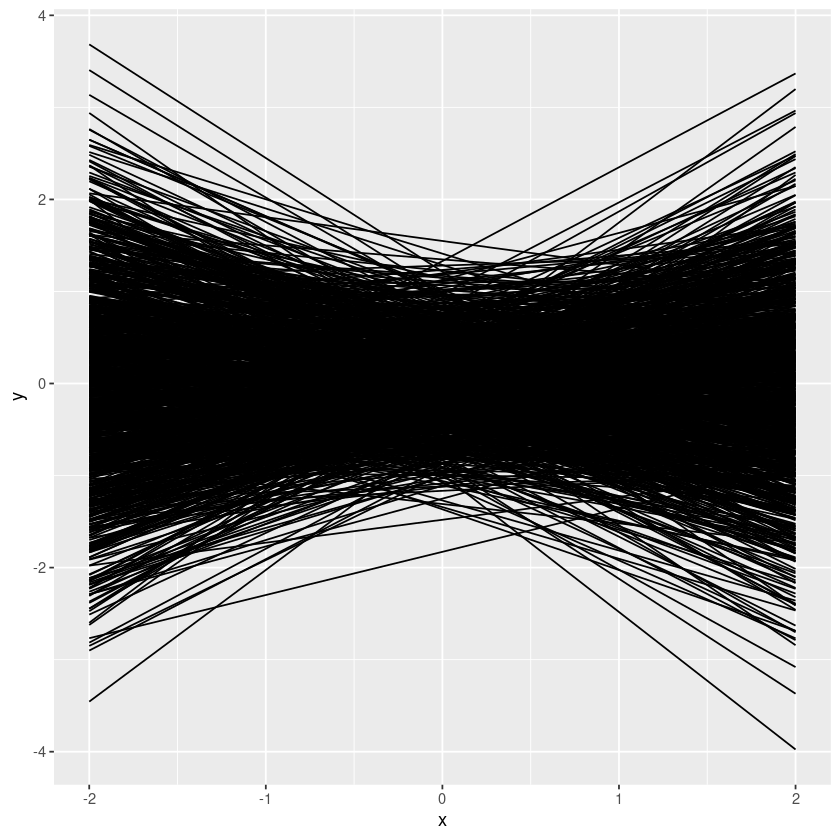

In [92]:
ggplot(priors_data, aes(x, y, group=identifier)) +
    geom_line()

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
a,3.031090e-07,0.09050694,-0.1446473,0.1446479
bAvgFood,-2.418554e-02,0.09088671,-0.1694401,0.1210690
sigma,9.911630e-01,0.06466168,0.8878212,1.0945049


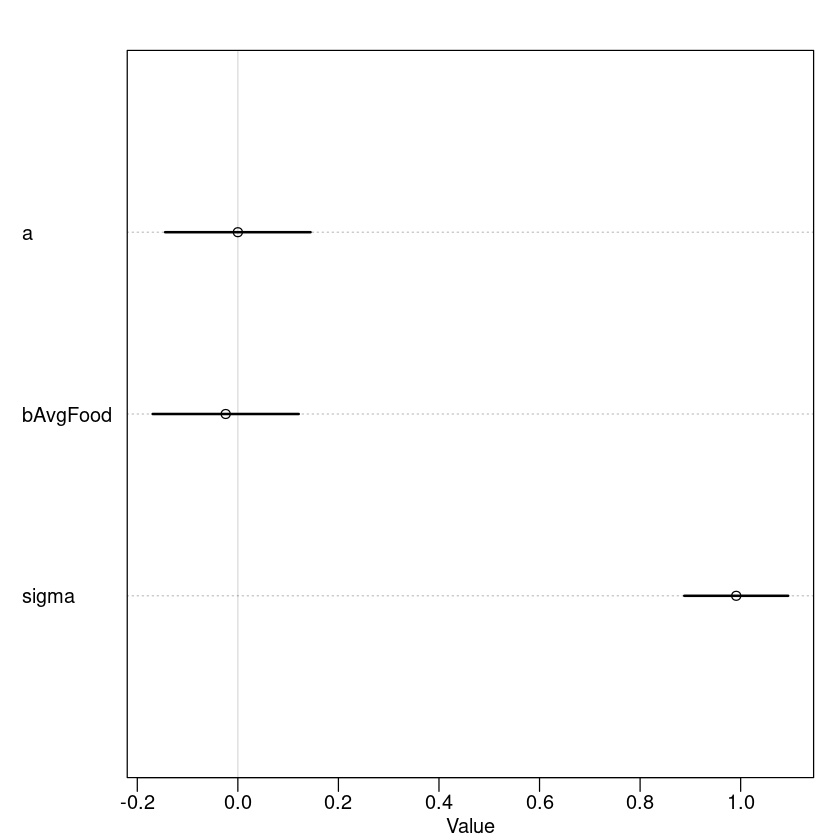

In [93]:
precis(m6h4)
plot(precis(m6h4))

So again, it seems that the avg food in the area doesn't affect the weight of  the foxes. We would infer that adding more food to an area would not make the foxes heavier.

**6H5** Now infer the causal impact of group size. Which covariates do you need to adjust for? Looking at the posterior distribution of the resulting model, what do you think explains these data? That is, can you explains the estimates for all three problems? How do they go together?

There are two paths from groupsize to weight:
1. $GroupSize \to Weight$: open, causal
2. $GroupSize \leftarrow AvgFood \to Weight$: open, not causal

We want to close the second route, so we'll condition on the AvgFood.

In [94]:
adjustmentSets(fox_dag, exposure="groupsize", outcome="weight")

{ avgfood }

,mean,sd,5.5%,94.5%
,<dbl>,<dbl>,<dbl>,<dbl>
a,4.871138e-08,0.08615819,-0.1376974,0.1376975
bAvgFood,4.772651e-01,0.17912305,0.1909919,0.7635383
bGroupSize,-5.735342e-01,0.17914159,-0.8598371,-0.2872313
sigma,9.420435e-01,0.06175249,0.8433511,1.0407360


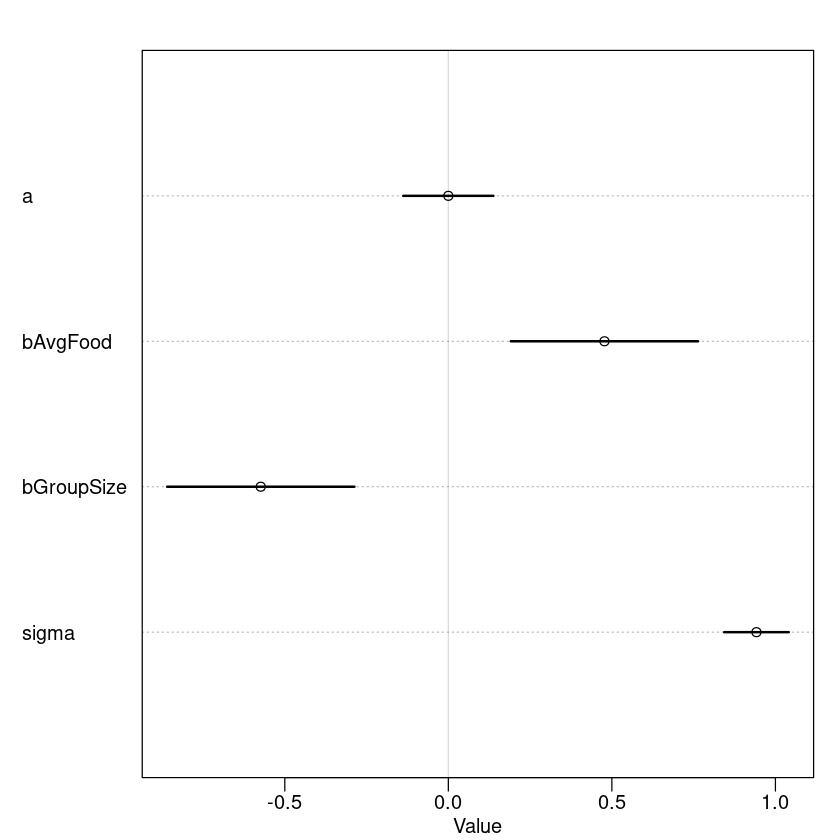

In [95]:
m6h5 <- quap(
    alist(
        Weight ~ dnorm(mu, sigma),
        mu <- a + bAvgFood * AvgFood + bGroupSize * GroupSize,
        a ~ dnorm(0, 0.5),
        bAvgFood ~ dnorm(0, 0.5),
        bGroupSize ~ dnorm(0, 0.5),
        sigma ~ dexp(1)
    ),
    data=d
)
precis(m6h5)
plot(precis(m6h5))

From this, it seems that the group size is negatively correlated with the weight of the foxes - that is, all else being equal, we would expect a fox in a larger group to have a lower weight than in a smaller one. Interestingly, here we see that average food is positively associated with the weight of the foxes, whereas when we considered it on its own it did not. It could be that "higher quality" territories (one with a higher avgfood) attract more foxes, and then the increased competition negates any of the positive benefits of having that extra food.

**6H6** Consider your own research question. Draw a DAG to represent it. What are the testable implications of you DAG? Are there any variables you could condition on to close all backdoor paths? Are there unobserved variables you have omitted? Would a reasonable colleague imagine additional threats to causal inference that you have ignored?

**6H7** For the DAG you made in the previous problem, can you write a data generating simulation for it? Can you design one or more statistical models to produce causal estimates? If so, try to calculate interesting counterfactuals. If not, use the simulation to estimate the size of teh bias you might expect. Under what conditions would you, for example, infer the opposite of a true causal effect?